In [ ]:
from collections import OrderedDict
from google.colab import drive
import matplotlib
matplotlib.rcParams['figure.figsize'] = [5, 4]
matplotlib.rcParams['font.size'] = 10
from matplotlib.ticker import PercentFormatter
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
from sklearn.metrics import accuracy_score, f1_score
from sklearn.preprocessing import StandardScaler
import torch
from torch import nn
from torch.autograd import grad, Variable
from torch.nn.functional import softmax
from torch.utils.data import DataLoader, Dataset

In [ ]:
!pip install pylogit

**Note:** The `pylogit` library needs to be installed manually for Colab. To solve the error `cannot import name 'Iterable' from 'collections' (/usr/lib/python3.10/collections/__init__.py)`, we can replace `collections` with `collections.abc` in the file `/usr/local/lib/python3.10/dist-packages/pylogit/choice_tools.py`.

In [ ]:
file_path = '/usr/local/lib/python3.10/dist-packages/pylogit/choice_tools.py'
with open(file_path, 'r') as file:
    lines = file.readlines()

lines[14] = 'from collections.abc import Iterable\n'

with open(file_path, 'w') as file:
    file.writelines(lines)

In [ ]:
import pylogit as pl

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# CMAP Dataset

## Data import

In [ ]:
size = 10000
var, alt = 'auto_cost', 0
path = '/content/drive/My Drive'
data1 = pd.read_csv(f'{path}/CMAP/chicago_processed.csv', index_col=0).sample(size, random_state=3)

In [ ]:
data1['high_edu'] = data1['educ'].isin([5, 6]).astype(int)
data1['hhveh_1'] = (data1['hhveh'] == 1).astype(int)
data1['hhsize_1'] = (data1['hhsize'] == 1).astype(int)
data1['high_inc'] = (data1['hhinc'] > 7).astype(int)

data1 = data1[['age', 'male', 'high_edu', 'hhsize_1', 'hhsize', 'hhveh', 'hhveh_1', 'high_inc', 'auto_time', 'auto_cost', 'train_time',
               'train_cost', 'active_time', 'mode']]

In [ ]:
data = pd.DataFrame(StandardScaler().fit_transform(data1), columns=data1.columns, index=data1.index)
data['mode'] = data1['mode']

In [ ]:
train_size = int(size*.7)
val_size = int(size*.1)
test_size = size - train_size - val_size

data_test = data.nlargest(test_size, var)
data_remain = data.drop(data_test.index)
data_train = data_remain.sample(train_size, random_state=3)
data_val = data_remain.drop(data_train.index)

## Data processing
2. Build a dataframe with average values, except for the visualized variable,
3. Develop a function to build dataframes for model regularity calculation, and
4. Load the data for training, validation, and testing.

In [ ]:
upper, lower = data[var].max(), data[var].min()
prb_size = 201
data_prb = pd.DataFrame(np.zeros((prb_size, len(data.columns))), columns=data.columns)
data_prb[var] = np.linspace(lower, upper, prb_size)

In [ ]:
num_var = data.columns.get_loc(var)

def gen_reg_df(data, upper, lower):
    'Function to build a dataset for regularity calculation'
    data_reg = data.copy()
    data_reg = data_reg.loc[data_reg.index.repeat(2)]
    data_reg.iloc[np.arange(1, len(data_reg), 2), num_var] += (upper - lower) / 200
    return data_reg

In [ ]:
class Load(Dataset):
    'Class to load the datasets for modeling'
    def __init__(self, data):
        x_set = data.drop(columns='mode')
        y_set = data['mode']
        self.X = Variable(torch.tensor(x_set.values).float(), requires_grad=True)
        self.y = torch.tensor(y_set.values)

    def __getitem__(self, index):
        return self.X[index], self.y[index]

    def __len__(self):
        return len(self.X)

In [ ]:
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

g = torch.Generator()
g.manual_seed(0)

train_loader = DataLoader(Load(data_train), batch_size=train_size//10, worker_init_fn=seed_worker, generator=g)
val_loader = DataLoader(Load(data_val), batch_size=val_size, worker_init_fn=seed_worker, generator=g)
test_loader = DataLoader(Load(data_test), batch_size=test_size, worker_init_fn=seed_worker, generator=g)

# Datasets for model analysis
prb_loader = DataLoader(Load(data_prb), batch_size=prb_size, worker_init_fn=seed_worker, generator=g)
train_reg_loader = DataLoader(Load(gen_reg_df(data_train, upper, lower)), batch_size=2*train_size, worker_init_fn=seed_worker, generator=g)
val_reg_loader = DataLoader(Load(gen_reg_df(data_val, upper, lower)), batch_size=2*val_size, worker_init_fn=seed_worker, generator=g)
test_reg_loader = DataLoader(Load(gen_reg_df(data_test, upper, lower)), batch_size=2*test_size, worker_init_fn=seed_worker, generator=g)

## True market shares

In [ ]:
l_alt = ['Auto', 'Train', 'Active']

def true_share(df):
    'Function to calculate the true market shares'
    y = df['mode'].replace(0, l_alt[0]).replace(1, l_alt[1]).replace(2, l_alt[2])
    return y.value_counts(normalize=True).round(3)[l_alt]

In [ ]:
# Training set
true_share(data_train)

mode
Auto      0.666
Train     0.091
Active    0.243
Name: proportion, dtype: float64

In [ ]:
# Validation set
true_share(data_val)

mode
Auto      0.667
Train     0.093
Active    0.240
Name: proportion, dtype: float64

In [ ]:
# Test set
true_share(data_test)

mode
Auto      0.786
Train     0.136
Active    0.078
Name: proportion, dtype: float64

# Random utility models (RUMs)
The RUMs are estimated based on unstandardized inputs and a data frame with wide format.

In [ ]:
def convert(df):
    'Function for data format conversion'
    df = df.reset_index(names='obs_id', drop=True)
    for a in ['auto', 'train', 'active']:
        df[f'ava_{a}'] = 1
    # Individual-specific variables
    ind_vars = df.columns.tolist()[:8]
    # Alternative-specific variables
    alt_vars = {u'time': dict([(0, 'auto_time'), (1, 'train_time'), (2, 'active_time')]),
                u'cost': dict([(0, 'auto_cost'), (1, 'train_cost')])}
    # Availability variables
    ava_vars = {0: 'ava_auto', 1: 'ava_train', 2: 'ava_active'}
    # Observation ID column
    df['obs_id'] = np.arange(df.shape[0], dtype=int) + 1
    # Wide format -> long format
    df_lg = pl.convert_wide_to_long(df, ind_vars, alt_vars, ava_vars, 'obs_id', 'mode', 'alt_id')
    return df_lg

In [ ]:
data1_test = data1.nlargest(test_size, var)
data1_remain = data1.drop(data1_test.index)
data1_train = data1_remain.sample(train_size, random_state=3)
data1_val = data1_remain.drop(data1_train.index)

In [ ]:
data1_train_lg = convert(data1_train)
data1_train_lg

obs_id  alt_id  mode  age  male  high_edu  hhsize_1  hhsize  hhveh  \
0           1       0     1   41     0         1         0       5      2   
1           1       1     0   41     0         1         0       5      2   
2           1       2     0   41     0         1         0       5      2   
3           2       0     0   39     0         1         0       4      1   
4           2       1     1   39     0         1         0       4      1   
...       ...     ...   ...  ...   ...       ...       ...     ...    ...   
20995    6999       1     0   44     0         0         0       4      2   
20996    6999       2     0   44     0         0         0       4      2   
20997    7000       0     1   39     0         0         0       3      2   
20998    7000       1     0   39     0         0         0       3      2   
20999    7000       2     0   39     0         0         0       3      2   

       hhveh_1  high_inc       time       cost  
0            0         1   8.050000   5.827333  
1            0         1  56.650000   2.541667  
2            0         1  36.083333   0.000000  
3            1         0  14.333333   8.253333  
4            1         0  47.766667   2.325000  
...        ...       ...        ...        ...  
20995        0         0  25.950000   2.158333  
20996        0         0  31.491667   0.000000  
20997        0         1  13.383333  10.048667  
20998        0         1  67.916667   2.308333  
20999        0         1  73.175000   0.000000  

[21000 rows x 13 columns]

## Multinomial logit (MNL)
Auto is set as the reference alternative for sociodemographics.

In [ ]:
spec = OrderedDict()
name = OrderedDict()

# Alternative-specific constants
spec['intercept'] = [1, 2]
name['intercept'] = ['asc_train', 'asc_active']

# Individual-specific variables
spec['age'] = [1, 2]
name['age'] = ['age_train', 'age_active']
spec['male'] = [1, 2]
name['male'] = ['male_train', 'male_active']
spec['high_edu'] = [1, 2]
name['high_edu'] = ['high_edu_train', 'high_edu_active']
spec['hhsize'] = [1, 2]
name['hhsize'] = ['hhsize_train', 'hhsize_active']
spec['hhsize_1'] = [1, 2]
name['hhsize_1'] = ['hhsize_1_train', 'hhsize_1_active']
spec['hhveh'] = [1, 2]
name['hhveh'] = ['hhveh_train', 'hhveh_active']
spec['hhveh_1'] = [1, 2]
name['hhveh_1'] = ['hhveh_1_train', 'hhveh_1_active']
spec['high_inc'] = [1, 2]
name['high_inc'] = ['high_inc_train', 'high_inc_active']

# Alternative-specific variables
spec['time'] = [0, 1, 2]
name['time'] = ['time_auto', 'time_train', 'time_active']
spec['cost'] = [0, 1]
name['cost'] = ['cost_auto', 'cost_train']

In [ ]:
mnl = pl.create_choice_model(data1_train_lg, alt_id_col='alt_id', obs_id_col='obs_id', choice_col='mode', specification=spec,
                             model_type='MNL', names=name)
mnl.fit_mle(np.zeros(23))
mnl.get_statsmodels_summary()

Log-likelihood at zero: -7,690.2860
Initial Log-likelihood: -7,690.2860


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:565: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  warn('Method %s does not use Hessian information (hess).' % method,


Estimation Time for Point Estimation: 0.89 seconds.
Final log-likelihood: -4,719.9655


<class 'statsmodels.iolib.summary.Summary'>
"""
                     Multinomial Logit Model Regression Results                    
===================================================================================
Dep. Variable:                        mode   No. Observations:                7,000
Model:             Multinomial Logit Model   Df Residuals:                    6,977
Method:                                MLE   Df Model:                           23
Date:                     Sun, 07 Apr 2024   Pseudo R-squ.:                   0.386
Time:                             02:58:04   Pseudo R-bar-squ.:               0.383
AIC:                             9,485.931   Log-Likelihood:             -4,719.966
BIC:                             9,643.565   LL-Null:                    -7,690.286
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
asc_train          -2.2972      0.561     -4.093      0.000      -3.397      -1.197
asc_active         -0.4984      0.204     -2.440      0.015      -0.899      -0.098
age_train          -0.0171      0.004     -4.308      0.000      -0.025      -0.009
age_active         -0.0148      0.003     -5.579      0.000      -0.020      -0.010
male_train          0.4443      0.093      4.762      0.000       0.261       0.627
male_active         0.4791      0.065      7.402      0.000       0.352       0.606
high_edu_train      0.3237      0.120      2.701      0.007       0.089       0.559
high_edu_active     0.5414      0.083      6.524      0.000       0.379       0.704
hhsize_train       -0.1359      0.057     -2.396      0.017      -0.247      -0.025
hhsize_active      -0.1630      0.038     -4.274      0.000      -0.238      -0.088
hhsize_1_train     -0.3814      0.144     -2.650      0.008      -0.663      -0.099
hhsize_1_active    -0.2661      0.100     -2.673      0.008      -0.461      -0.071
hhveh_train        -0.7157      0.066    -10.813      0.000      -0.845      -0.586
hhveh_active       -0.7328      0.047    -15.697      0.000      -0.824      -0.641
hhveh_1_train      -0.5150      0.096     -5.370      0.000      -0.703      -0.327
hhveh_1_active     -0.4113      0.066     -6.230      0.000      -0.541      -0.282
high_inc_train      0.5784      0.117      4.951      0.000       0.349       0.807
high_inc_active     0.2615      0.080      3.274      0.001       0.105       0.418
time_auto          -0.1266      0.009    -13.685      0.000      -0.145      -0.108
time_train         -0.0544      0.004    -14.364      0.000      -0.062      -0.047
time_active        -0.0696      0.002    -28.753      0.000      -0.074      -0.065
cost_auto          -0.2732      0.022    -12.487      0.000      -0.316      -0.230
cost_train          0.0504      0.200      0.252      0.801      -0.341       0.442
===================================================================================
"""

## Mixed logit (MXL)

In [ ]:
# mix_var = ['time_auto', 'time_train', 'time_active', 'cost_auto', 'cost_train']

# mxl = pl.create_choice_model(data1_train_lg, alt_id_col='alt_id', obs_id_col='obs_id', choice_col='mode', specification=spec,
#                              model_type='Mixed Logit', names=name, mixing_id_col='obs_id', mixing_vars=mix_var)
# mxl.fit_mle(np.zeros(28), num_draws=100, seed=13)
# mxl.get_statsmodels_summary()

## Results

In [ ]:
data1_val_lg = convert(data1_val)
data1_test_lg = convert(data1_test)

In [ ]:
def dcm_performance(pred, df):
    'Function to calculate performance metrics for DCMs'
    prb = pred.reshape(len(df), 3)
    y = df['mode']
    y_pred = prb.argmax(1)
    ll = 0
    for i in range(len(df)):
        ll += np.log(prb[i, y.iloc[i]])
    acc = accuracy_score(y, y_pred)
    f1 = f1_score(y, y_pred, average='weighted')
    return [ll, acc, f1]

In [ ]:
def print_metrics(met_train, met_val, met_test):
    'Function to print performance metrics'
    print(f'Training set:   LL = {met_train[0]:<7.1f} | acc = {met_train[1]:.1%} | F1 = {met_train[2]:.1%}')
    print(f'Validation set: LL = {met_val[0]:<7.1f} | acc = {met_val[1]:.1%} | F1 = {met_val[2]:.1%}')
    print(f'Test set:       LL = {met_test[0]:<7.1f} | acc = {met_test[1]:.1%} | F1 = {met_test[2]:.1%}')

In [ ]:
# MNL model
met_train_mnl = dcm_performance(mnl.predict(data1_train_lg), data1_train)
met_val_mnl = dcm_performance(mnl.predict(data1_val_lg), data1_val)
met_test_mnl = dcm_performance(mnl.predict(data1_test_lg), data1_test)
print_metrics(met_train_mnl, met_val_mnl, met_test_mnl)

Training set:   LL = -4720.0 | acc = 72.6% | F1 = 69.3%
Validation set: LL = -673.2  | acc = 74.5% | F1 = 71.1%
Test set:       LL = -2025.7 | acc = 72.2% | F1 = 72.1%


In [ ]:
# MXL model
# met_train_mxl = dcm_performance(mxl.predict(data1_train_lg, num_draws=500, seed=13), data1_train)
# met_val_mxl = dcm_performance(mxl.predict(data1_val_lg, num_draws=500, seed=13), data1_val)
# met_test_mxl = dcm_performance(mxl.predict(data1_test_lg, num_draws=500, seed=13), data1_test)
# print_metrics(met_train_mxl, met_val_mxl, met_test_mxl)

In [ ]:
upper1, lower1 = data1[var].max(), data1[var].min()
data1_prb = pd.DataFrame(np.tile(data1.mean(), (prb_size, 1)), columns=data1.columns)
data1_prb['mode'] = pd.Series([np.random.randint(0, 3) for i in range(prb_size)])
data1_prb[var] = np.linspace(lower1, upper1, prb_size)
data1_prb_lg = convert(data1_prb)

In [ ]:
# A colorblind-friendly colormap
l_color = ['#377eb8', '#ff7f00', '#4daf4a', '#f781bf', '#a65628', '#984ea3', '#999999', '#e41a1c', '#dede00']
thr = (data1_remain[var].max() + data1_test[var].min()) / 2

def RUM_sub(l_prb, name):
    'Function to plot substitution patterns'
    plt.axvline(thr, ls='--', color='darkgray')
    for a in range(3):
        plt.plot(data1_prb[var], l_prb[:, a], color=l_color[a], label=l_alt[a])
    plt.legend(frameon=False)
    plt.xlabel(f'{var} ($)')
    plt.ylabel('Probability')
    # plt.show()
    plt.savefig(f'{path}/Regularity_results/{name}_10K_S.png', bbox_inches='tight', dpi=200)

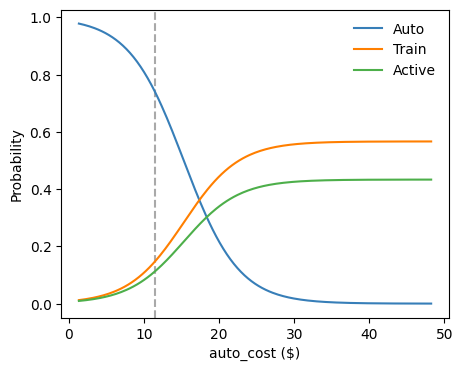

In [ ]:
# MNL model
l_prb_MNL = mnl.predict(data1_prb_lg).reshape(len(data1_prb), 3)
RUM_sub(l_prb_MNL, 'MNL')

In [ ]:
# MXL model
# l_prb_MXL = mxl.predict(data1_prb_lg, num_draws=500, seed=13).reshape(len(data1_prb), 3)
# RUM_sub(l_prb_MXL, 'MXL')

In [ ]:
data1_train_reg = gen_reg_df(data1_train, upper1, lower1)
data1_val_reg = gen_reg_df(data1_val, upper1, lower1)
data1_test_reg = gen_reg_df(data1_test, upper1, lower1)

data1_train_reg_lg = convert(data1_train_reg)
data1_val_reg_lg = convert(data1_val_reg)
data1_test_reg_lg = convert(data1_test_reg)

In [ ]:
eps = (lower1 - upper1) / 1e6

def cal_reg(l_prb_reg):
    'Function to calculate strong and weak regularities'
    diff = np.subtract(l_prb_reg[1::2], l_prb_reg[::2])
    reg_st = sum(diff < eps) / len(diff)
    reg_wk = sum(diff < -eps) / len(diff)
    print(f'Strong regularity = {reg_st:.3f}')
    print(f'Weak regularity   = {reg_wk:.3f}')
    return [reg_st, reg_wk]

In [ ]:
# MNL model
print('Training set:')
prb_reg = mnl.predict(data1_train_reg_lg).reshape(2*train_size, 3)[:, alt]
met_train_mnl.extend(cal_reg(prb_reg))

print('-'*30, '\nValidation set:')
prb_reg = mnl.predict(data1_val_reg_lg).reshape(2*val_size, 3)[:, alt]
met_val_mnl.extend(cal_reg(prb_reg))

print('-'*30, '\nTest set:')
prb_reg = mnl.predict(data1_test_reg_lg).reshape(2*test_size, 3)[:, alt]
met_test_mnl.extend(cal_reg(prb_reg))

Training set:
Strong regularity = 1.000
Weak regularity   = 1.000
------------------------------ 
Validation set:
Strong regularity = 1.000
Weak regularity   = 1.000
------------------------------ 
Test set:
Strong regularity = 0.984
Weak regularity   = 1.000


In [ ]:
# MXL model
# print('Training set:')
# prb_reg = mxl.predict(data1_train_reg_lg, num_draws=500, seed=13).reshape(2*train_size, 3)[:, alt]
# met_train_mxl.extend(cal_reg(prb_reg))

# print('-'*30, '\nValidation set:')
# prb_reg = mxl.predict(data1_val_reg_lg, num_draws=500, seed=13).reshape(2*val_size, 3)[:, alt]
# met_val_mxl.extend(cal_reg(prb_reg))

# print('-'*30, '\nTest set:')
# prb_reg = mxl.predict(data1_test_reg_lg, num_draws=500, seed=13).reshape(2*test_size, 3)[:, alt]
# met_test_mxl.extend(cal_reg(prb_reg))

In [ ]:
l_index = ['Log-likelihood', 'Accuracy', 'F1 score', 'Strong regularity', 'Weak regularity']

# results_train = pd.DataFrame({'MNL': met_train_mnl, 'MXL': met_train_mxl}, index=l_index)
# results_val = pd.DataFrame({'MNL': met_val_mnl, 'MXL': met_val_mxl}, index=l_index)
# results_test = pd.DataFrame({'MNL': met_test_mnl, 'MXL': met_test_mxl}, index=l_index)

results_train = pd.DataFrame({'MNL': met_train_mnl}, index=l_index)
results_val = pd.DataFrame({'MNL': met_val_mnl}, index=l_index)
results_test = pd.DataFrame({'MNL': met_test_mnl}, index=l_index)

results_train_std = pd.DataFrame({'MNL': 0}, index=l_index)
results_val_std = pd.DataFrame({'MNL': 0}, index=l_index)
results_test_std = pd.DataFrame({'MNL': 0}, index=l_index)

# Neural networks (NNs)

## Model structure

In [ ]:
def cal_loss(model, X, y, GR, base, lambd, criterion):
    '''
    Function to regularize the loss function
    lambd: weight of GR -> (1-lambd) is the weight of loss
    base: indicator of regularizing the sum
    '''
    loss = criterion(model(X), y)
    # Utility GR
    if GR == 'UGR':
        utl = model(X)
        g1 = grad(utl[:, 0], X, torch.ones_like(utl[:, 0]), create_graph=True)[0][:, 8:10]
        g2 = grad(utl[:, 1], X, torch.ones_like(utl[:, 1]), create_graph=True)[0][:, 10:12]
        g3 = grad(utl[:, 2], X, torch.ones_like(utl[:, 2]), create_graph=True)[0][:, 12]
    # Probability GR
    elif GR == 'PGR':
        prb = softmax(model(X), dim=1)
        g1 = grad(prb[:, 0], X, torch.ones_like(prb[:, 0]), create_graph=True)[0][:, 8:10]
        g2 = grad(prb[:, 1], X, torch.ones_like(prb[:, 1]), create_graph=True)[0][:, 10:12]
        g3 = grad(prb[:, 2], X, torch.ones_like(prb[:, 2]), create_graph=True)[0][:, 12]
    # Loss GR
    elif GR == 'LGR':
        log_prb = torch.log(softmax(model(X), dim=1))
        g1 = grad(log_prb[:, 0]*(y==0), X, torch.ones_like(log_prb[:, 0]), create_graph=True)[0][:, 8:10]
        g2 = grad(log_prb[:, 1]*(y==1), X, torch.ones_like(log_prb[:, 0]), create_graph=True)[0][:, 10:12]
        g3 = grad(log_prb[:, 2]*(y==2), X, torch.ones_like(log_prb[:, 0]), create_graph=True)[0][:, 12]
    # Without GR
    else:
        return loss

    # Sum- vs. norm-GR
    if base == 'sum':
        reg = g1[g1 > 0].sum() + g2[g2 > 0].sum() + g3[g3 > 0].sum()
    else:
        reg = torch.pow(g1, 2).sum() + torch.pow(g2, 2).sum() + torch.pow(g3, 2).sum()
    return loss + lambd * reg

In [ ]:
def train_loop(model, GR, base, lambd, optimizer, criterion):
    'Function for DNN training in each epoch'
    for X, y in train_loader:
        loss = cal_loss(model, X, y, GR, base, lambd, criterion)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    return loss

In [ ]:
def cal_metrics(model, criterion, loader):
    ll = 0
    y_true, y_pred = [], []
    for X, y in loader:
        pred = model(X)
        y_true.extend(y)
        loss = criterion(pred, y).item()
        ll -= loss * len(X)
        y_pred.extend(pred.argmax(1))
    f1 = f1_score(y_true, y_pred, average='weighted')
    acc = accuracy_score(y_true, y_pred)
    return ll, acc, f1, loss

In [ ]:
def test(model, criterion):
    'Function for NN testing'
    model.eval()
    with torch.no_grad():
        # For loss, accuracy, and F1 score calculation
        met_train = cal_metrics(model, criterion, train_loader)
        met_val = cal_metrics(model, criterion, val_loader)
        met_test = cal_metrics(model, criterion, test_loader)

        # For probability calculation
        for X, _ in prb_loader:
            prb = softmax(model(X), dim=1).detach().numpy()

        # For regularity calculation
        for X_train, _ in train_reg_loader:
            prb_reg_train = softmax(model(X_train), dim=1)[:, alt].detach().numpy()
        for X_val, _ in val_reg_loader:
            prb_reg_val = softmax(model(X_val), dim=1)[:, alt].detach().numpy()
        for X_test, _ in test_reg_loader:
            prb_reg_test = softmax(model(X_test), dim=1)[:, alt].detach().numpy()
    return met_train, met_val, met_test, prb, prb_reg_train, prb_reg_val, prb_reg_test

In [ ]:
def plot_loss(agg_loss):
    'Function to plot training and validation losses per epoch'
    for l_loss in agg_loss:
        plt.plot(range(1, len(l_loss[0])+1), l_loss[0], color=l_color[0], alpha=.2)
        plt.plot(range(1, len(l_loss[1])+1), l_loss[1], color=l_color[1], alpha=.2)
    plt.xlabel('Epoch')
    plt.ylabel('Cross-entropy loss')
    plt.show()

In [ ]:
num_models = 10

def train(NN, num_epochs, GR, base, lambd):
    'Function for NN training'
    agg_loss, l_met_train, l_met_val, l_met_test, l_prb, l_prb_reg_train, l_prb_reg_val, l_prb_reg_test = [[] for i in range(8)]
    for m in range(1, num_models+1):
        torch.manual_seed(m)
        model = NN()
        l_loss_train_epoch, l_loss_val_epoch = [], []
        optimizer = torch.optim.AdamW(model.parameters(), weight_decay=0)
        criterion = nn.CrossEntropyLoss()
        for i in range(num_epochs):
            l_loss_train_epoch.append(train_loop(model, GR, base, lambd, optimizer, criterion).detach().numpy())
            model.eval()
            with torch.no_grad():
                l_loss_val_epoch.append(cal_metrics(model, criterion, val_loader)[3])
            model.train()
        agg_loss.append([l_loss_train_epoch, l_loss_val_epoch])
        met_train, met_val, met_test, prb, reg_train, reg_val, reg_test = test(model, criterion)
        [x.append(y) for x, y in zip([l_met_train, l_met_val, l_met_test, l_prb, l_prb_reg_train, l_prb_reg_val, l_prb_reg_test],
                                     [met_train, met_val, met_test, prb, reg_train, reg_val, reg_test])]
        print(f'Model {m:<2}')
        print_metrics(met_train, met_val, met_test)
    plot_loss(agg_loss)
    return l_met_train, l_met_val, l_met_test, l_prb, l_prb_reg_train, l_prb_reg_val, l_prb_reg_test

## Functions for analysis
We evaluate the models by:
- test loss, accuracy, and F1 score;
- strong and weak regularities.

In [ ]:
def NN_agg(l_met):
    'Function to analyze aggregate NN performance'
    # Averages
    avg_ll = np.mean([r[0] for r in l_met])
    avg_acc = np.mean([r[1] for r in l_met])
    avg_f1 = np.mean([r[2] for r in l_met])
    # Standard deviations
    std_ll = np.std([r[0] for r in l_met])
    std_acc = np.std([r[1] for r in l_met])
    std_f1 = np.std([r[2] for r in l_met])
    print(f'Average log-likelihood = {avg_ll:.1f} ({std_ll:.1f})')
    print(f'Average accuracy       = {avg_acc:.1%} ({std_acc:.1%})')
    print(f'Average F1 score       = {avg_f1:.1%} ({std_f1:.1%})')
    return [avg_ll, avg_acc, avg_f1], [std_ll, std_acc, std_f1]

In [ ]:
def NN_sub(l_prb, NN, base, GR, lambd):
    'Function to plot substitution patterns'
    plt.axvline(thr, ls='--', color='darkgray')
    for a in range(3):
        for p in l_prb[:, :, a]:
            plt.plot(data1_prb[var], p, color=l_color[a], alpha=.10)
        plt.plot(data1_prb[var], np.mean(l_prb[:, :, a], axis=0), color=l_color[a], label=l_alt[a])
    plt.legend(frameon=False)
    plt.xlabel(f'{var} ($)')
    plt.ylabel('Probability')
    if GR == 'none':
        plt.savefig(f'{path}/Regularity_results/{NN.__name__}_10K_S.png', bbox_inches='tight', dpi=200)
    else:
        plt.savefig(f'{path}/Regularity_results/{NN.__name__}_{base}_{GR}_{lambd}_10K_S.png', bbox_inches='tight', dpi=200)
    plt.show()

In [ ]:
def NN_reg(l_prb_reg):
    'Function to calculate strong and weak regularities for NNs'
    l_st_reg, l_wk_reg = [], []
    for prb_reg in l_prb_reg:
        diff = np.subtract(prb_reg[1::2], prb_reg[::2])
        l_st_reg.append(sum(diff < eps) / len(diff))
        l_wk_reg.append(sum(diff < -eps) / len(diff))
    avg_st_reg = np.mean(l_st_reg)
    avg_wk_reg = np.mean(l_wk_reg)
    std_st_reg = np.std(l_st_reg)
    std_wk_reg = np.std(l_wk_reg)
    print(f'Strong regularity = {avg_st_reg:.3f} ({std_st_reg:.3f})')
    print(f'Weak regularity   = {avg_wk_reg:.3f} ({std_wk_reg:.3f})')
    return [avg_st_reg, avg_wk_reg], [std_st_reg, std_wk_reg]

In [ ]:
def comparison(lambdas, agg_ll, agg_acc, agg_f1, l_st_reg, l_wk_reg, NN, base, GR):
    'Function to compare NN models'
    print('-'*30, '\nModel comparison:')
    fig, ax1 = plt.subplots()

    # Plot average test log-likelihood
    ax1.grid(linestyle='--', color='lightgray')
    ax1.plot(np.log10(lambdas), agg_ll, marker='.', color=l_color[0], label='Log-likelihood')
    ax1.set_xlabel(r'$\lg(\lambda)$')
    ax1.set_ylabel('Test log-likelihood (average)')

    # Plot average test accuracy
    ax2 = ax1.twinx()
    ax2.plot(np.log10(lambdas), agg_acc, marker='.', color=l_color[1], label='Accuracy')
    ax2.set_ylabel(r'Test accuracy, $F_1$ score, regularities (average)')

    # Plot average test F1 score
    ax2.plot(np.log10(lambdas), agg_f1, marker='.', color=l_color[2], label=r'$F_1$ score')

    # Plot average regularities
    ax2.plot(np.log10(lambdas), l_st_reg, marker='.', linestyle='dashed', color=l_color[3], label='Strong regularity')
    ax2.plot(np.log10(lambdas), l_wk_reg, marker='.', linestyle='dashed', color=l_color[4], label='Weak regularity')

    h1, l1 = ax1.get_legend_handles_labels()
    h2, l2 = ax2.get_legend_handles_labels()
    box = ax1.get_position()
    ax1.legend(h1+h2, l1+l2, frameon=False, loc='upper center', bbox_to_anchor=(.5, -.15), ncol=2)
    fig.savefig(f'{path}/Regularity_results/{NN.__name__}_{base}_{GR}_10K_S.png', bbox_inches='tight', dpi=200)

In [ ]:
def result(NN, num_epochs, GR, lambdas=[0], base='sum'):
    'Function to display all DNN results'
    agg_ll_test, agg_acc_test, agg_f1_test, l_st_reg, l_wk_reg = [[] for i in range(5)]
    for lambd in lambdas:
        print(f'Penalty = {lambd}')
        print('-'*30)
        if NN == DNN and lambd > 1:
            l_met_train, l_met_val, l_met_test, l_prb, l_prb_reg_train, l_prb_reg_val, l_prb_reg_test = train(NN, num_epochs+20, GR, base, lambd)
        else:
            l_met_train, l_met_val, l_met_test, l_prb, l_prb_reg_train, l_prb_reg_val, l_prb_reg_test = train(NN, num_epochs, GR, base, lambd)
        # Average LL, accuracy, and F1 score
        print('-'*30, '\nTraining set:')
        avg_met_train, std_met_train = NN_agg(l_met_train)
        print('-'*30, '\nValidation set:')
        avg_met_val, std_met_val = NN_agg(l_met_val)
        print('-'*30, '\nTest set:')
        avg_met_test, std_met_test = NN_agg(l_met_test)
        [x.append(y) for x, y in zip([agg_ll_test, agg_acc_test, agg_f1_test], avg_met_test)]

        # Regularities
        if GR == 'none':
            name = f'{NN.__name__}'
        else:
            name = f'{NN.__name__}, {base}-{GR} ({lambd})'
        print('-'*30, '\nTraining set:')
        [x.extend(y) for x, y in zip([avg_met_train, std_met_train], NN_reg(l_prb_reg_train))]
        results_train[name] = avg_met_train
        results_train_std[name] = std_met_train
        print('-'*30, '\nValidation set:')
        [x.extend(y) for x, y in zip([avg_met_val, std_met_val], NN_reg(l_prb_reg_val))]
        results_val[name] = avg_met_val
        results_val_std[name] = std_met_val
        print('-'*30, '\nTest set:')
        avg_reg, std_reg = NN_reg(l_prb_reg_test)
        [x.extend(y) for x, y in zip([avg_met_test, std_met_test], [avg_reg, std_reg])]
        results_test[name] = avg_met_test
        results_test_std[name] = std_met_test
        [x.append(y) for x, y in zip([l_st_reg, l_wk_reg], avg_reg)]

        # Substitution pattern
        print('-'*30)
        NN_sub(np.array(l_prb), NN, base, GR, lambd)
    if len(lambdas) > 1:
        comparison(lambdas, agg_ll_test, agg_acc_test, agg_f1_test, l_st_reg, l_wk_reg, NN, base, GR)

## Deep neural networks (DNNs)

In [ ]:
class DNN(nn.Module):
    'Class of DNNs (4 hidden layers x 100 neurons)'
    def __init__(self):
        super(DNN, self).__init__()
        self.seq = nn.Sequential(
            nn.Linear(13, 100),
            nn.ReLU(),
            nn.Linear(100, 100),
            nn.ReLU(),
            nn.Linear(100, 100),
            nn.ReLU(),
            nn.Linear(100, 100),
            nn.ReLU(),
            nn.Linear(100, 3)
        )

    def forward(self, x):
        return self.seq(x)

### Without GR

Penalty = 0
------------------------------
Model 1 
Training set:   LL = -4284.3 | acc = 74.7% | F1 = 71.9%
Validation set: LL = -648.5  | acc = 74.2% | F1 = 70.9%
Test set:       LL = -1318.0 | acc = 78.6% | F1 = 72.3%
Model 2 
Training set:   LL = -4279.2 | acc = 74.1% | F1 = 71.2%
Validation set: LL = -663.4  | acc = 73.4% | F1 = 69.9%
Test set:       LL = -1531.7 | acc = 78.9% | F1 = 71.7%
Model 3 
Training set:   LL = -4293.1 | acc = 74.5% | F1 = 71.5%
Validation set: LL = -657.9  | acc = 73.9% | F1 = 70.7%
Test set:       LL = -1581.0 | acc = 78.7% | F1 = 71.2%
Model 4 
Training set:   LL = -4289.9 | acc = 74.3% | F1 = 71.5%
Validation set: LL = -663.4  | acc = 73.4% | F1 = 70.2%
Test set:       LL = -1239.1 | acc = 78.6% | F1 = 71.6%
Model 5 
Training set:   LL = -4286.1 | acc = 74.5% | F1 = 71.5%
Validation set: LL = -659.5  | acc = 73.4% | F1 = 69.8%
Test set:       LL = -1467.1 | acc = 78.8% | F1 = 71.4%
Model 6 
Training set:   LL = -4280.2 | acc = 74.9% | F1 = 72.2%
Validat

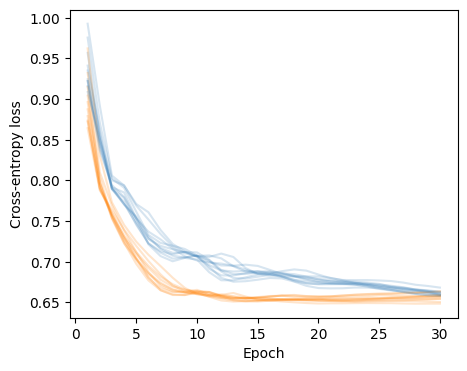

------------------------------ 
Training set:
Average log-likelihood = -4292.7 (21.5)
Average accuracy       = 74.5% (0.2%)
Average F1 score       = 71.7% (0.3%)
------------------------------ 
Validation set:
Average log-likelihood = -656.6 (4.6)
Average accuracy       = 73.7% (0.3%)
Average F1 score       = 70.3% (0.4%)
------------------------------ 
Test set:
Average log-likelihood = -1356.1 (134.1)
Average accuracy       = 78.3% (1.1%)
Average F1 score       = 72.2% (1.0%)
------------------------------ 
Training set:
Strong regularity = 0.881 (0.045)
Weak regularity   = 0.898 (0.042)
------------------------------ 
Validation set:
Strong regularity = 0.883 (0.045)
Weak regularity   = 0.898 (0.042)
------------------------------ 
Test set:
Strong regularity = 0.317 (0.240)
Weak regularity   = 0.487 (0.230)
------------------------------


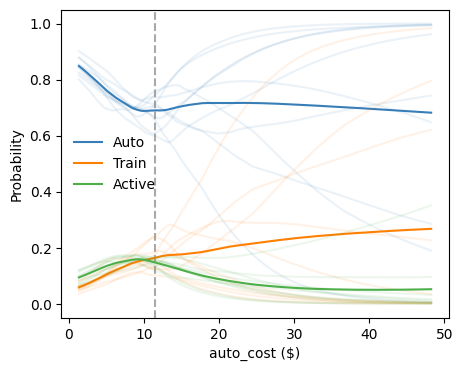

In [ ]:
result(DNN, 30, 'none')

### PGR

Penalty = 100
------------------------------
Model 1 
Training set:   LL = -4989.4 | acc = 70.0% | F1 = 64.7%
Validation set: LL = -703.5  | acc = 70.1% | F1 = 64.7%
Test set:       LL = -1282.5 | acc = 77.5% | F1 = 71.0%
Model 2 
Training set:   LL = -4859.0 | acc = 71.1% | F1 = 66.2%
Validation set: LL = -690.3  | acc = 71.4% | F1 = 66.4%
Test set:       LL = -1251.8 | acc = 77.7% | F1 = 71.2%
Model 3 
Training set:   LL = -4978.2 | acc = 70.2% | F1 = 65.1%
Validation set: LL = -701.2  | acc = 70.9% | F1 = 65.7%
Test set:       LL = -1251.3 | acc = 77.3% | F1 = 70.9%
Model 4 
Training set:   LL = -4922.9 | acc = 70.9% | F1 = 66.2%
Validation set: LL = -698.1  | acc = 71.0% | F1 = 66.3%
Test set:       LL = -1257.0 | acc = 78.0% | F1 = 71.4%
Model 5 
Training set:   LL = -5071.8 | acc = 70.0% | F1 = 64.4%
Validation set: LL = -715.3  | acc = 70.4% | F1 = 64.7%
Test set:       LL = -1326.5 | acc = 77.2% | F1 = 70.4%
Model 6 
Training set:   LL = -4886.8 | acc = 70.8% | F1 = 65.8%
Valid

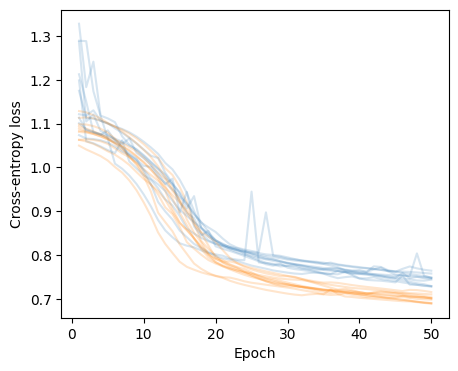

------------------------------ 
Training set:
Average log-likelihood = -4959.0 (66.2)
Average accuracy       = 70.6% (0.4%)
Average F1 score       = 65.5% (0.6%)
------------------------------ 
Validation set:
Average log-likelihood = -699.9 (8.2)
Average accuracy       = 70.7% (0.5%)
Average F1 score       = 65.5% (0.7%)
------------------------------ 
Test set:
Average log-likelihood = -1277.3 (48.2)
Average accuracy       = 77.3% (0.6%)
Average F1 score       = 70.8% (0.3%)
------------------------------ 
Training set:
Strong regularity = 1.000 (0.000)
Weak regularity   = 1.000 (0.000)
------------------------------ 
Validation set:
Strong regularity = 1.000 (0.000)
Weak regularity   = 1.000 (0.000)
------------------------------ 
Test set:
Strong regularity = 1.000 (0.001)
Weak regularity   = 1.000 (0.000)
------------------------------


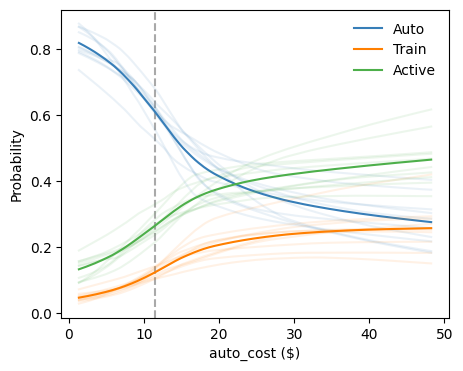

Penalty = 10
------------------------------
Model 1 
Training set:   LL = -4501.9 | acc = 73.6% | F1 = 70.7%
Validation set: LL = -650.3  | acc = 73.6% | F1 = 70.2%
Test set:       LL = -1163.6 | acc = 79.0% | F1 = 73.0%
Model 2 
Training set:   LL = -4497.9 | acc = 73.3% | F1 = 70.3%
Validation set: LL = -653.1  | acc = 73.9% | F1 = 70.9%
Test set:       LL = -1183.0 | acc = 78.9% | F1 = 73.2%
Model 3 
Training set:   LL = -4439.1 | acc = 73.5% | F1 = 70.5%
Validation set: LL = -649.2  | acc = 73.9% | F1 = 70.7%
Test set:       LL = -1231.1 | acc = 78.8% | F1 = 71.9%
Model 4 
Training set:   LL = -4511.3 | acc = 73.5% | F1 = 69.9%
Validation set: LL = -656.5  | acc = 74.9% | F1 = 71.2%
Test set:       LL = -1197.8 | acc = 78.5% | F1 = 71.5%
Model 5 
Training set:   LL = -4487.1 | acc = 73.3% | F1 = 70.6%
Validation set: LL = -646.8  | acc = 74.5% | F1 = 71.7%
Test set:       LL = -1307.1 | acc = 78.9% | F1 = 71.6%
Model 6 
Training set:   LL = -4542.3 | acc = 72.9% | F1 = 69.8%
Valida

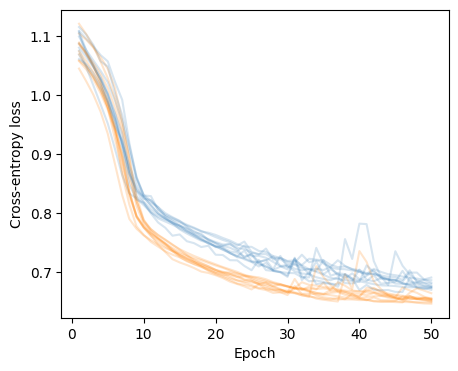

------------------------------ 
Training set:
Average log-likelihood = -4503.9 (38.0)
Average accuracy       = 73.3% (0.3%)
Average F1 score       = 70.1% (0.6%)
------------------------------ 
Validation set:
Average log-likelihood = -653.6 (4.6)
Average accuracy       = 73.8% (0.7%)
Average F1 score       = 70.4% (0.9%)
------------------------------ 
Test set:
Average log-likelihood = -1211.7 (39.9)
Average accuracy       = 78.7% (0.2%)
Average F1 score       = 72.3% (0.7%)
------------------------------ 
Training set:
Strong regularity = 0.999 (0.000)
Weak regularity   = 1.000 (0.000)
------------------------------ 
Validation set:
Strong regularity = 0.999 (0.001)
Weak regularity   = 1.000 (0.000)
------------------------------ 
Test set:
Strong regularity = 0.952 (0.047)
Weak regularity   = 0.998 (0.005)
------------------------------


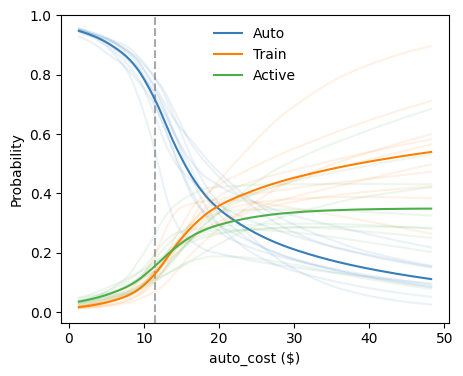

Penalty = 1
------------------------------
Model 1 
Training set:   LL = -4446.0 | acc = 73.5% | F1 = 70.3%
Validation set: LL = -650.6  | acc = 74.1% | F1 = 70.8%
Test set:       LL = -1156.2 | acc = 78.6% | F1 = 73.2%
Model 2 
Training set:   LL = -4462.3 | acc = 73.5% | F1 = 70.4%
Validation set: LL = -653.6  | acc = 73.4% | F1 = 70.1%
Test set:       LL = -1184.9 | acc = 78.9% | F1 = 72.5%
Model 3 
Training set:   LL = -4435.0 | acc = 73.5% | F1 = 70.5%
Validation set: LL = -648.0  | acc = 74.0% | F1 = 70.8%
Test set:       LL = -1210.4 | acc = 78.5% | F1 = 71.9%
Model 4 
Training set:   LL = -4453.6 | acc = 73.6% | F1 = 70.5%
Validation set: LL = -652.9  | acc = 74.1% | F1 = 70.8%
Test set:       LL = -1195.8 | acc = 79.1% | F1 = 72.7%
Model 5 
Training set:   LL = -4433.5 | acc = 73.6% | F1 = 70.5%
Validation set: LL = -647.4  | acc = 73.7% | F1 = 70.3%
Test set:       LL = -1220.5 | acc = 79.1% | F1 = 72.7%
Model 6 
Training set:   LL = -4431.3 | acc = 73.7% | F1 = 70.7%
Validat

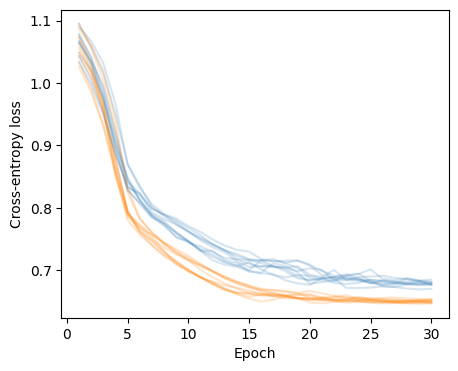

------------------------------ 
Training set:
Average log-likelihood = -4447.0 (15.8)
Average accuracy       = 73.5% (0.1%)
Average F1 score       = 70.4% (0.2%)
------------------------------ 
Validation set:
Average log-likelihood = -649.8 (2.3)
Average accuracy       = 73.8% (0.3%)
Average F1 score       = 70.5% (0.4%)
------------------------------ 
Test set:
Average log-likelihood = -1188.6 (25.8)
Average accuracy       = 78.8% (0.2%)
Average F1 score       = 72.5% (0.4%)
------------------------------ 
Training set:
Strong regularity = 0.999 (0.000)
Weak regularity   = 1.000 (0.000)
------------------------------ 
Validation set:
Strong regularity = 0.999 (0.001)
Weak regularity   = 1.000 (0.000)
------------------------------ 
Test set:
Strong regularity = 0.958 (0.020)
Weak regularity   = 0.999 (0.003)
------------------------------


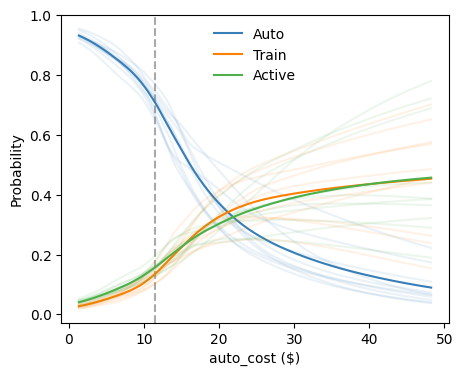

Penalty = 0.1
------------------------------
Model 1 
Training set:   LL = -4307.7 | acc = 74.4% | F1 = 71.8%
Validation set: LL = -643.0  | acc = 73.7% | F1 = 70.7%
Test set:       LL = -1195.6 | acc = 78.9% | F1 = 73.5%
Model 2 
Training set:   LL = -4333.3 | acc = 74.1% | F1 = 71.2%
Validation set: LL = -648.0  | acc = 73.8% | F1 = 70.4%
Test set:       LL = -1255.0 | acc = 79.0% | F1 = 72.9%
Model 3 
Training set:   LL = -4307.6 | acc = 74.2% | F1 = 71.1%
Validation set: LL = -652.3  | acc = 73.7% | F1 = 70.3%
Test set:       LL = -1223.0 | acc = 78.8% | F1 = 72.8%
Model 4 
Training set:   LL = -4355.8 | acc = 73.9% | F1 = 70.9%
Validation set: LL = -654.8  | acc = 73.9% | F1 = 70.6%
Test set:       LL = -1213.2 | acc = 78.8% | F1 = 71.9%
Model 5 
Training set:   LL = -4308.2 | acc = 74.3% | F1 = 71.5%
Validation set: LL = -648.1  | acc = 73.9% | F1 = 70.8%
Test set:       LL = -1395.6 | acc = 79.0% | F1 = 72.1%
Model 6 
Training set:   LL = -4337.5 | acc = 74.3% | F1 = 71.4%
Valid

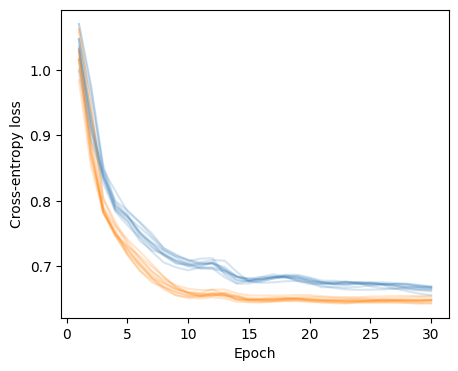

------------------------------ 
Training set:
Average log-likelihood = -4325.0 (17.7)
Average accuracy       = 74.2% (0.2%)
Average F1 score       = 71.4% (0.3%)
------------------------------ 
Validation set:
Average log-likelihood = -647.9 (3.4)
Average accuracy       = 73.9% (0.2%)
Average F1 score       = 70.7% (0.2%)
------------------------------ 
Test set:
Average log-likelihood = -1243.5 (55.1)
Average accuracy       = 78.8% (0.2%)
Average F1 score       = 72.6% (0.6%)
------------------------------ 
Training set:
Strong regularity = 0.998 (0.001)
Weak regularity   = 1.000 (0.000)
------------------------------ 
Validation set:
Strong regularity = 0.998 (0.001)
Weak regularity   = 0.999 (0.001)
------------------------------ 
Test set:
Strong regularity = 0.857 (0.099)
Weak regularity   = 0.974 (0.037)
------------------------------


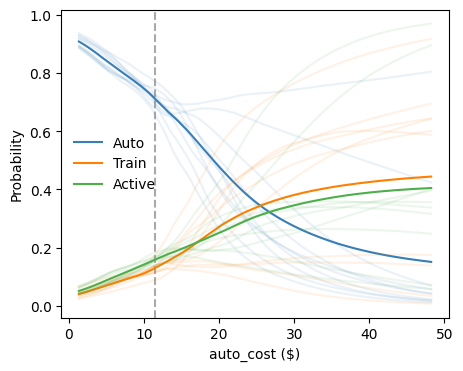

Penalty = 0.01
------------------------------
Model 1 
Training set:   LL = -4278.8 | acc = 74.7% | F1 = 72.0%
Validation set: LL = -645.6  | acc = 74.5% | F1 = 71.6%
Test set:       LL = -1283.7 | acc = 78.6% | F1 = 72.3%
Model 2 
Training set:   LL = -4258.2 | acc = 74.6% | F1 = 71.8%
Validation set: LL = -650.3  | acc = 73.9% | F1 = 70.6%
Test set:       LL = -1417.8 | acc = 79.0% | F1 = 72.8%
Model 3 
Training set:   LL = -4240.0 | acc = 74.7% | F1 = 72.0%
Validation set: LL = -648.4  | acc = 73.9% | F1 = 70.6%
Test set:       LL = -1291.5 | acc = 79.1% | F1 = 73.8%
Model 4 
Training set:   LL = -4298.4 | acc = 74.4% | F1 = 71.6%
Validation set: LL = -653.5  | acc = 74.3% | F1 = 71.1%
Test set:       LL = -1201.6 | acc = 78.6% | F1 = 72.3%
Model 5 
Training set:   LL = -4249.6 | acc = 74.8% | F1 = 71.9%
Validation set: LL = -653.6  | acc = 74.2% | F1 = 70.8%
Test set:       LL = -1401.8 | acc = 79.0% | F1 = 72.3%
Model 6 
Training set:   LL = -4280.2 | acc = 74.7% | F1 = 72.1%
Vali

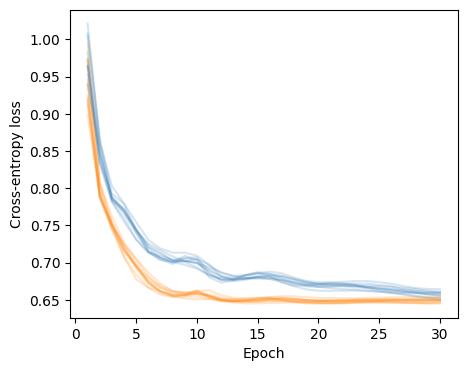

------------------------------ 
Training set:
Average log-likelihood = -4268.8 (20.2)
Average accuracy       = 74.7% (0.1%)
Average F1 score       = 71.9% (0.2%)
------------------------------ 
Validation set:
Average log-likelihood = -649.4 (2.7)
Average accuracy       = 74.0% (0.3%)
Average F1 score       = 70.8% (0.3%)
------------------------------ 
Test set:
Average log-likelihood = -1319.9 (74.0)
Average accuracy       = 78.8% (0.3%)
Average F1 score       = 72.8% (0.6%)
------------------------------ 
Training set:
Strong regularity = 0.993 (0.003)
Weak regularity   = 0.997 (0.001)
------------------------------ 
Validation set:
Strong regularity = 0.992 (0.004)
Weak regularity   = 0.996 (0.003)
------------------------------ 
Test set:
Strong regularity = 0.728 (0.124)
Weak regularity   = 0.915 (0.076)
------------------------------


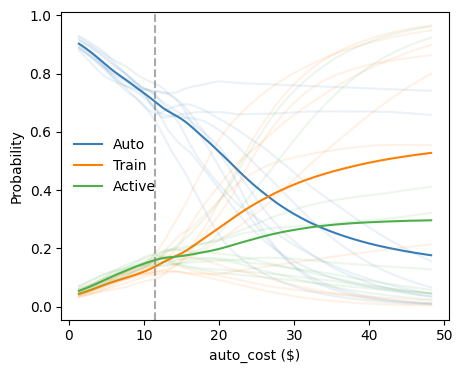

Penalty = 0.001
------------------------------
Model 1 
Training set:   LL = -4295.6 | acc = 74.7% | F1 = 72.0%
Validation set: LL = -642.8  | acc = 74.0% | F1 = 70.7%
Test set:       LL = -1269.7 | acc = 78.3% | F1 = 72.4%
Model 2 
Training set:   LL = -4259.8 | acc = 74.7% | F1 = 72.0%
Validation set: LL = -654.6  | acc = 73.8% | F1 = 70.7%
Test set:       LL = -1636.7 | acc = 79.1% | F1 = 72.7%
Model 3 
Training set:   LL = -4245.7 | acc = 74.8% | F1 = 72.1%
Validation set: LL = -651.5  | acc = 73.6% | F1 = 70.6%
Test set:       LL = -1530.2 | acc = 78.9% | F1 = 71.7%
Model 4 
Training set:   LL = -4280.1 | acc = 74.4% | F1 = 71.6%
Validation set: LL = -655.8  | acc = 74.3% | F1 = 71.1%
Test set:       LL = -1271.8 | acc = 78.5% | F1 = 71.1%
Model 5 
Training set:   LL = -4278.2 | acc = 74.6% | F1 = 71.8%
Validation set: LL = -657.5  | acc = 73.4% | F1 = 70.1%
Test set:       LL = -1488.2 | acc = 79.0% | F1 = 71.3%
Model 6 
Training set:   LL = -4292.6 | acc = 74.6% | F1 = 72.0%
Val

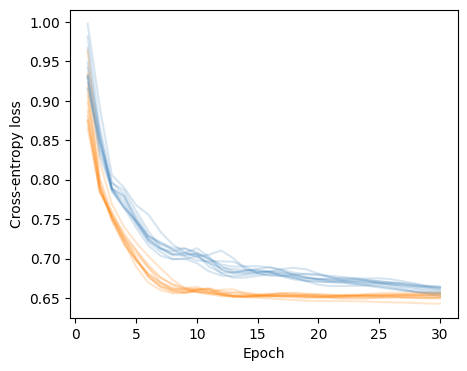

------------------------------ 
Training set:
Average log-likelihood = -4282.1 (19.4)
Average accuracy       = 74.7% (0.1%)
Average F1 score       = 71.9% (0.2%)
------------------------------ 
Validation set:
Average log-likelihood = -652.1 (3.9)
Average accuracy       = 73.9% (0.4%)
Average F1 score       = 70.7% (0.4%)
------------------------------ 
Test set:
Average log-likelihood = -1374.2 (132.9)
Average accuracy       = 78.8% (0.3%)
Average F1 score       = 72.1% (0.7%)
------------------------------ 
Training set:
Strong regularity = 0.968 (0.011)
Weak regularity   = 0.977 (0.009)
------------------------------ 
Validation set:
Strong regularity = 0.966 (0.010)
Weak regularity   = 0.975 (0.008)
------------------------------ 
Test set:
Strong regularity = 0.486 (0.138)
Weak regularity   = 0.740 (0.154)
------------------------------


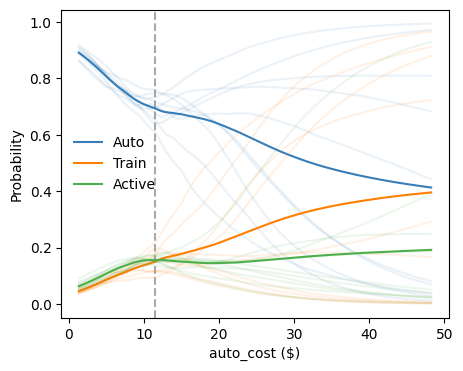

Penalty = 0.0001
------------------------------
Model 1 
Training set:   LL = -4284.5 | acc = 74.7% | F1 = 71.9%
Validation set: LL = -648.4  | acc = 73.6% | F1 = 70.1%
Test set:       LL = -1279.8 | acc = 78.8% | F1 = 73.5%
Model 2 
Training set:   LL = -4277.0 | acc = 74.4% | F1 = 71.5%
Validation set: LL = -658.6  | acc = 73.2% | F1 = 69.7%
Test set:       LL = -1514.4 | acc = 79.1% | F1 = 72.2%
Model 3 
Training set:   LL = -4284.7 | acc = 74.5% | F1 = 71.6%
Validation set: LL = -655.5  | acc = 73.7% | F1 = 70.2%
Test set:       LL = -1608.4 | acc = 79.2% | F1 = 72.2%
Model 4 
Training set:   LL = -4287.5 | acc = 74.3% | F1 = 71.5%
Validation set: LL = -661.8  | acc = 73.4% | F1 = 70.2%
Test set:       LL = -1220.0 | acc = 78.4% | F1 = 71.2%
Model 5 
Training set:   LL = -4269.3 | acc = 74.6% | F1 = 71.9%
Validation set: LL = -660.7  | acc = 73.6% | F1 = 70.2%
Test set:       LL = -1465.2 | acc = 79.3% | F1 = 72.2%
Model 6 
Training set:   LL = -4281.2 | acc = 74.7% | F1 = 72.1%
Va

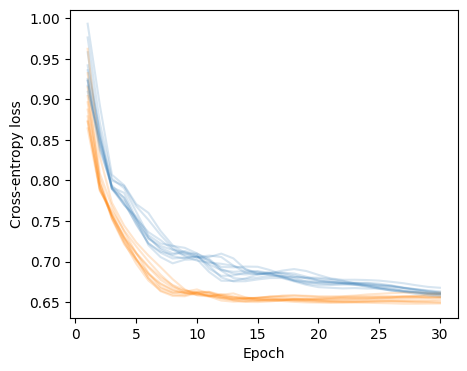

------------------------------ 
Training set:
Average log-likelihood = -4291.1 (19.5)
Average accuracy       = 74.5% (0.1%)
Average F1 score       = 71.7% (0.2%)
------------------------------ 
Validation set:
Average log-likelihood = -655.1 (4.4)
Average accuracy       = 73.6% (0.5%)
Average F1 score       = 70.2% (0.5%)
------------------------------ 
Test set:
Average log-likelihood = -1348.3 (143.9)
Average accuracy       = 78.8% (0.6%)
Average F1 score       = 72.5% (1.0%)
------------------------------ 
Training set:
Strong regularity = 0.918 (0.031)
Weak regularity   = 0.933 (0.029)
------------------------------ 
Validation set:
Strong regularity = 0.919 (0.028)
Weak regularity   = 0.932 (0.026)
------------------------------ 
Test set:
Strong regularity = 0.391 (0.246)
Weak regularity   = 0.587 (0.231)
------------------------------


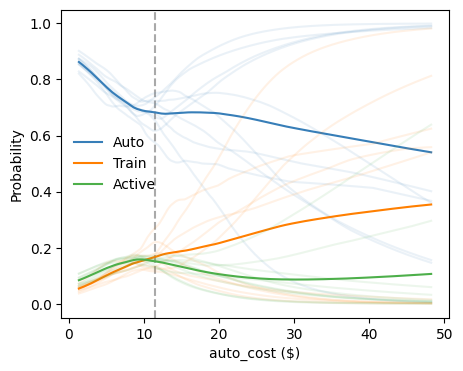

------------------------------ 
Model comparison:


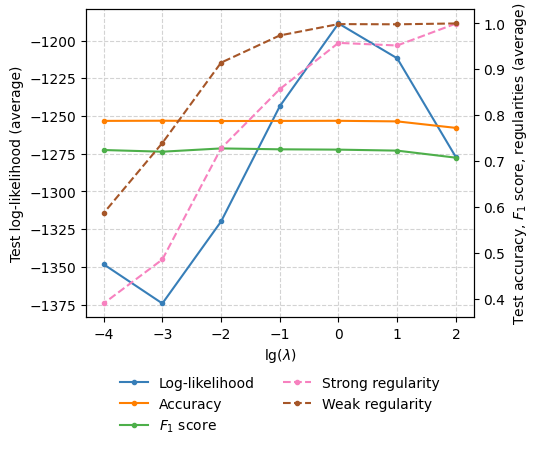

In [ ]:
# With sum
result(DNN, 30, 'PGR', [10**i for i in range(2, -5, -1)])

### UGR

Penalty = 100
------------------------------
Model 1 
Training set:   LL = -4960.9 | acc = 70.7% | F1 = 65.5%
Validation set: LL = -696.8  | acc = 71.4% | F1 = 66.0%
Test set:       LL = -1245.6 | acc = 78.2% | F1 = 71.1%
Model 2 
Training set:   LL = -4989.5 | acc = 70.7% | F1 = 65.4%
Validation set: LL = -708.4  | acc = 70.4% | F1 = 65.0%
Test set:       LL = -1245.6 | acc = 77.8% | F1 = 70.8%
Model 3 
Training set:   LL = -4788.3 | acc = 71.9% | F1 = 67.0%
Validation set: LL = -677.4  | acc = 73.9% | F1 = 69.1%
Test set:       LL = -1206.6 | acc = 78.5% | F1 = 69.3%
Model 4 
Training set:   LL = -4911.7 | acc = 71.2% | F1 = 66.1%
Validation set: LL = -693.3  | acc = 72.4% | F1 = 67.2%
Test set:       LL = -1202.3 | acc = 78.6% | F1 = 69.5%
Model 5 
Training set:   LL = -5023.6 | acc = 70.5% | F1 = 65.3%
Validation set: LL = -706.9  | acc = 71.6% | F1 = 66.1%
Test set:       LL = -1348.3 | acc = 77.5% | F1 = 70.8%
Model 6 
Training set:   LL = -4943.5 | acc = 71.0% | F1 = 66.2%
Valid

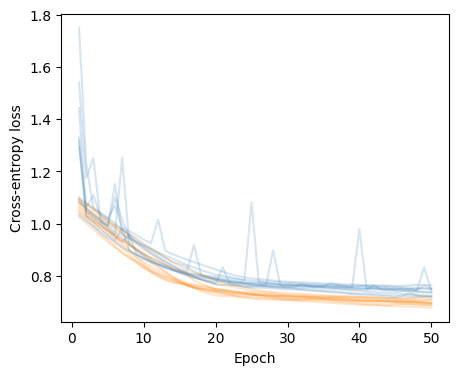

------------------------------ 
Training set:
Average log-likelihood = -4936.7 (93.3)
Average accuracy       = 71.0% (0.4%)
Average F1 score       = 66.0% (0.6%)
------------------------------ 
Validation set:
Average log-likelihood = -696.4 (11.5)
Average accuracy       = 71.7% (1.0%)
Average F1 score       = 66.5% (1.2%)
------------------------------ 
Test set:
Average log-likelihood = -1259.0 (56.2)
Average accuracy       = 78.1% (0.4%)
Average F1 score       = 70.5% (1.0%)
------------------------------ 
Training set:
Strong regularity = 0.963 (0.061)
Weak regularity   = 0.972 (0.047)
------------------------------ 
Validation set:
Strong regularity = 0.959 (0.063)
Weak regularity   = 0.970 (0.050)
------------------------------ 
Test set:
Strong regularity = 0.978 (0.063)
Weak regularity   = 0.987 (0.038)
------------------------------


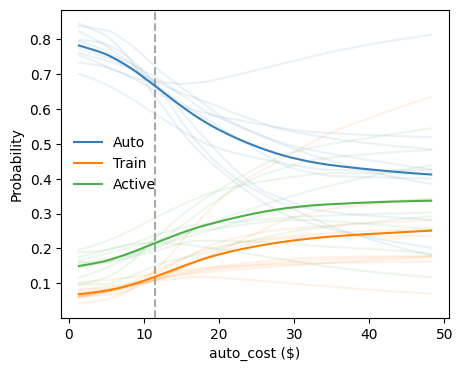

Penalty = 10
------------------------------
Model 1 
Training set:   LL = -4524.5 | acc = 73.1% | F1 = 68.8%
Validation set: LL = -651.9  | acc = 73.7% | F1 = 69.4%
Test set:       LL = -1156.8 | acc = 78.0% | F1 = 70.9%
Model 2 
Training set:   LL = -4634.5 | acc = 72.7% | F1 = 68.1%
Validation set: LL = -666.0  | acc = 73.8% | F1 = 69.3%
Test set:       LL = -1257.5 | acc = 78.3% | F1 = 69.6%
Model 3 
Training set:   LL = -4500.5 | acc = 73.3% | F1 = 69.3%
Validation set: LL = -648.0  | acc = 73.9% | F1 = 69.7%
Test set:       LL = -1131.9 | acc = 78.9% | F1 = 71.8%
Model 4 
Training set:   LL = -4537.2 | acc = 72.9% | F1 = 69.6%
Validation set: LL = -659.2  | acc = 73.6% | F1 = 70.0%
Test set:       LL = -1306.2 | acc = 78.8% | F1 = 72.6%
Model 5 
Training set:   LL = -4562.0 | acc = 73.0% | F1 = 68.6%
Validation set: LL = -649.3  | acc = 74.5% | F1 = 70.0%
Test set:       LL = -1157.5 | acc = 78.6% | F1 = 69.3%
Model 6 
Training set:   LL = -4521.1 | acc = 73.3% | F1 = 69.6%
Valida

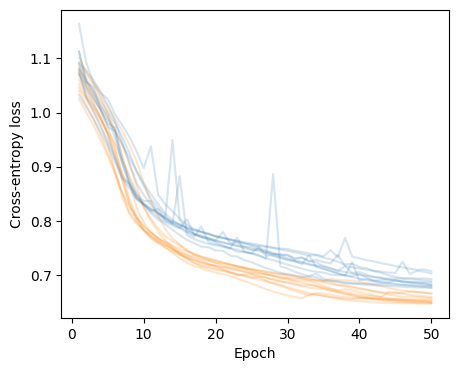

------------------------------ 
Training set:
Average log-likelihood = -4551.5 (65.3)
Average accuracy       = 73.0% (0.4%)
Average F1 score       = 69.0% (0.8%)
------------------------------ 
Validation set:
Average log-likelihood = -654.8 (6.5)
Average accuracy       = 73.9% (0.4%)
Average F1 score       = 69.8% (0.7%)
------------------------------ 
Test set:
Average log-likelihood = -1185.7 (57.8)
Average accuracy       = 78.6% (0.3%)
Average F1 score       = 71.4% (1.3%)
------------------------------ 
Training set:
Strong regularity = 0.997 (0.003)
Weak regularity   = 0.998 (0.003)
------------------------------ 
Validation set:
Strong regularity = 0.997 (0.003)
Weak regularity   = 0.998 (0.002)
------------------------------ 
Test set:
Strong regularity = 0.993 (0.011)
Weak regularity   = 1.000 (0.000)
------------------------------


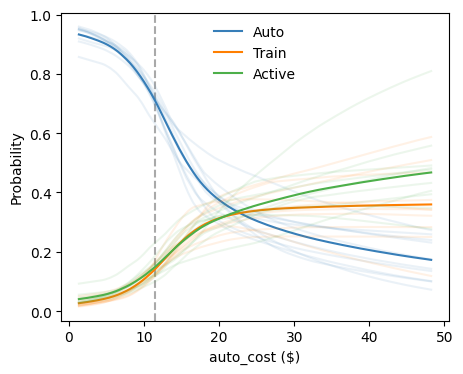

Penalty = 1
------------------------------
Model 1 
Training set:   LL = -4503.1 | acc = 73.1% | F1 = 69.7%
Validation set: LL = -648.8  | acc = 73.4% | F1 = 69.7%
Test set:       LL = -1130.7 | acc = 78.2% | F1 = 72.9%
Model 2 
Training set:   LL = -4565.5 | acc = 72.9% | F1 = 68.2%
Validation set: LL = -659.2  | acc = 73.0% | F1 = 68.2%
Test set:       LL = -1160.9 | acc = 78.5% | F1 = 69.9%
Model 3 
Training set:   LL = -4490.4 | acc = 73.5% | F1 = 69.8%
Validation set: LL = -650.3  | acc = 73.8% | F1 = 69.8%
Test set:       LL = -1157.7 | acc = 78.6% | F1 = 71.7%
Model 4 
Training set:   LL = -4506.5 | acc = 73.1% | F1 = 69.8%
Validation set: LL = -655.0  | acc = 74.4% | F1 = 71.0%
Test set:       LL = -1144.9 | acc = 78.1% | F1 = 73.0%
Model 5 
Training set:   LL = -4506.5 | acc = 73.1% | F1 = 69.1%
Validation set: LL = -653.1  | acc = 73.0% | F1 = 68.9%
Test set:       LL = -1123.2 | acc = 79.5% | F1 = 72.4%
Model 6 
Training set:   LL = -4502.4 | acc = 73.4% | F1 = 69.9%
Validat

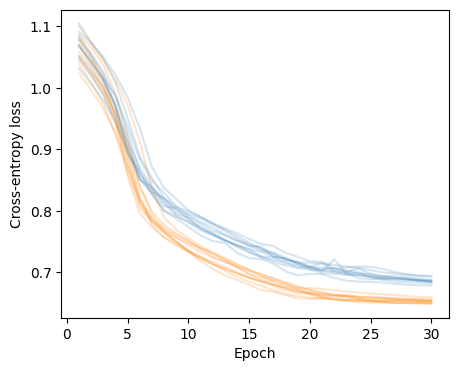

------------------------------ 
Training set:
Average log-likelihood = -4514.9 (26.5)
Average accuracy       = 73.2% (0.2%)
Average F1 score       = 69.3% (0.7%)
------------------------------ 
Validation set:
Average log-likelihood = -652.8 (3.0)
Average accuracy       = 73.6% (0.4%)
Average F1 score       = 69.5% (0.8%)
------------------------------ 
Test set:
Average log-likelihood = -1144.8 (15.3)
Average accuracy       = 78.5% (0.4%)
Average F1 score       = 72.1% (1.3%)
------------------------------ 
Training set:
Strong regularity = 0.998 (0.001)
Weak regularity   = 1.000 (0.001)
------------------------------ 
Validation set:
Strong regularity = 0.999 (0.001)
Weak regularity   = 1.000 (0.000)
------------------------------ 
Test set:
Strong regularity = 0.990 (0.005)
Weak regularity   = 0.999 (0.001)
------------------------------


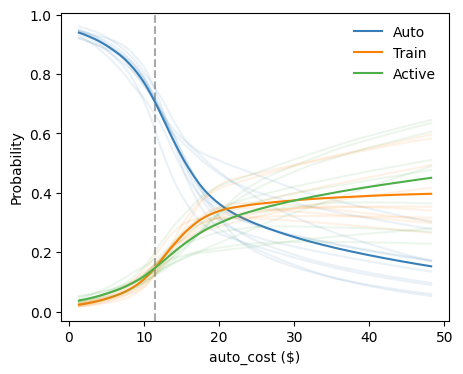

Penalty = 0.1
------------------------------
Model 1 
Training set:   LL = -4396.4 | acc = 73.7% | F1 = 70.4%
Validation set: LL = -647.2  | acc = 73.8% | F1 = 70.4%
Test set:       LL = -1129.4 | acc = 78.8% | F1 = 72.9%
Model 2 
Training set:   LL = -4399.5 | acc = 73.9% | F1 = 70.8%
Validation set: LL = -648.2  | acc = 74.0% | F1 = 70.7%
Test set:       LL = -1174.7 | acc = 79.2% | F1 = 72.8%
Model 3 
Training set:   LL = -4381.7 | acc = 74.0% | F1 = 70.9%
Validation set: LL = -648.5  | acc = 74.3% | F1 = 70.9%
Test set:       LL = -1184.0 | acc = 78.8% | F1 = 72.4%
Model 4 
Training set:   LL = -4401.3 | acc = 73.6% | F1 = 70.6%
Validation set: LL = -653.0  | acc = 73.6% | F1 = 70.3%
Test set:       LL = -1151.2 | acc = 78.8% | F1 = 72.5%
Model 5 
Training set:   LL = -4391.0 | acc = 74.0% | F1 = 71.1%
Validation set: LL = -646.9  | acc = 74.0% | F1 = 70.9%
Test set:       LL = -1160.2 | acc = 79.0% | F1 = 72.5%
Model 6 
Training set:   LL = -4389.3 | acc = 73.8% | F1 = 70.7%
Valid

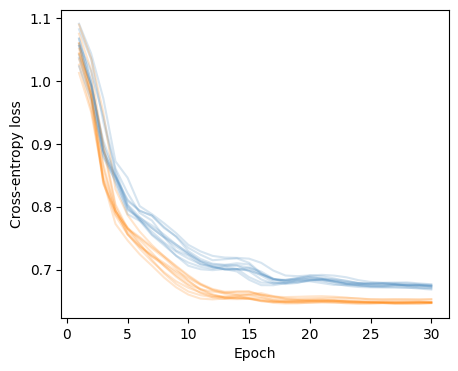

------------------------------ 
Training set:
Average log-likelihood = -4398.3 (13.5)
Average accuracy       = 73.8% (0.2%)
Average F1 score       = 70.7% (0.2%)
------------------------------ 
Validation set:
Average log-likelihood = -648.5 (2.2)
Average accuracy       = 73.7% (0.4%)
Average F1 score       = 70.4% (0.5%)
------------------------------ 
Test set:
Average log-likelihood = -1167.9 (27.6)
Average accuracy       = 78.9% (0.3%)
Average F1 score       = 72.7% (0.3%)
------------------------------ 
Training set:
Strong regularity = 0.998 (0.001)
Weak regularity   = 1.000 (0.000)
------------------------------ 
Validation set:
Strong regularity = 0.998 (0.001)
Weak regularity   = 1.000 (0.000)
------------------------------ 
Test set:
Strong regularity = 0.923 (0.087)
Weak regularity   = 0.983 (0.040)
------------------------------


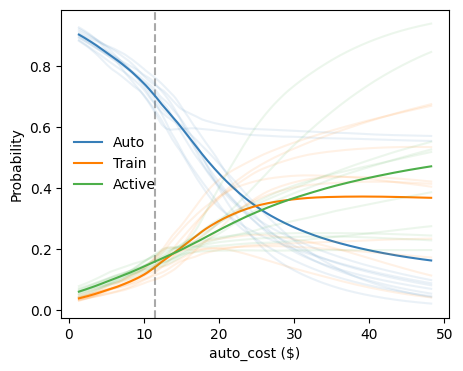

Penalty = 0.01
------------------------------
Model 1 
Training set:   LL = -4294.3 | acc = 74.7% | F1 = 71.9%
Validation set: LL = -644.7  | acc = 74.3% | F1 = 71.1%
Test set:       LL = -1180.8 | acc = 78.8% | F1 = 72.4%
Model 2 
Training set:   LL = -4300.0 | acc = 74.3% | F1 = 71.4%
Validation set: LL = -647.6  | acc = 73.5% | F1 = 70.0%
Test set:       LL = -1222.1 | acc = 79.0% | F1 = 73.1%
Model 3 
Training set:   LL = -4266.6 | acc = 74.6% | F1 = 71.8%
Validation set: LL = -647.3  | acc = 74.0% | F1 = 70.9%
Test set:       LL = -1186.0 | acc = 78.8% | F1 = 73.5%
Model 4 
Training set:   LL = -4317.6 | acc = 74.2% | F1 = 71.2%
Validation set: LL = -656.8  | acc = 73.8% | F1 = 70.6%
Test set:       LL = -1214.0 | acc = 79.0% | F1 = 72.4%
Model 5 
Training set:   LL = -4282.7 | acc = 74.5% | F1 = 71.7%
Validation set: LL = -651.5  | acc = 74.1% | F1 = 70.8%
Test set:       LL = -1370.8 | acc = 78.8% | F1 = 72.0%
Model 6 
Training set:   LL = -4287.4 | acc = 74.7% | F1 = 71.9%
Vali

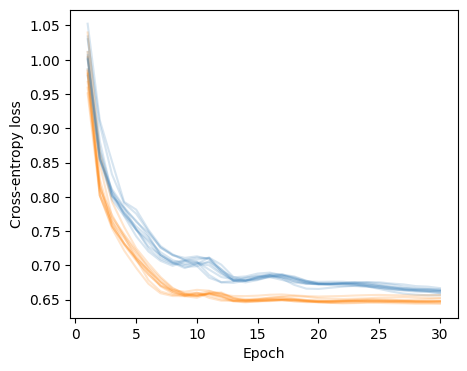

------------------------------ 
Training set:
Average log-likelihood = -4294.3 (17.5)
Average accuracy       = 74.5% (0.2%)
Average F1 score       = 71.7% (0.3%)
------------------------------ 
Validation set:
Average log-likelihood = -648.7 (3.7)
Average accuracy       = 74.1% (0.3%)
Average F1 score       = 70.9% (0.4%)
------------------------------ 
Test set:
Average log-likelihood = -1229.2 (61.3)
Average accuracy       = 78.8% (0.2%)
Average F1 score       = 72.6% (0.5%)
------------------------------ 
Training set:
Strong regularity = 0.996 (0.002)
Weak regularity   = 0.998 (0.001)
------------------------------ 
Validation set:
Strong regularity = 0.996 (0.003)
Weak regularity   = 0.998 (0.002)
------------------------------ 
Test set:
Strong regularity = 0.805 (0.134)
Weak regularity   = 0.934 (0.096)
------------------------------


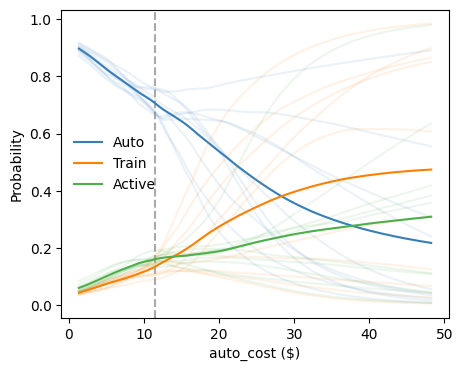

Penalty = 0.001
------------------------------
Model 1 
Training set:   LL = -4290.8 | acc = 74.7% | F1 = 72.0%
Validation set: LL = -642.5  | acc = 74.6% | F1 = 71.5%
Test set:       LL = -1284.6 | acc = 78.8% | F1 = 71.7%
Model 2 
Training set:   LL = -4246.0 | acc = 75.0% | F1 = 72.3%
Validation set: LL = -653.3  | acc = 73.4% | F1 = 70.2%
Test set:       LL = -1414.8 | acc = 79.0% | F1 = 73.4%
Model 3 
Training set:   LL = -4269.0 | acc = 74.6% | F1 = 72.0%
Validation set: LL = -651.4  | acc = 74.1% | F1 = 71.2%
Test set:       LL = -1345.3 | acc = 79.4% | F1 = 73.6%
Model 4 
Training set:   LL = -4306.4 | acc = 74.5% | F1 = 71.7%
Validation set: LL = -658.6  | acc = 73.9% | F1 = 70.9%
Test set:       LL = -1312.9 | acc = 78.8% | F1 = 71.6%
Model 5 
Training set:   LL = -4256.9 | acc = 74.8% | F1 = 72.1%
Validation set: LL = -657.8  | acc = 73.6% | F1 = 70.1%
Test set:       LL = -1537.8 | acc = 78.8% | F1 = 71.6%
Model 6 
Training set:   LL = -4285.3 | acc = 74.5% | F1 = 71.7%
Val

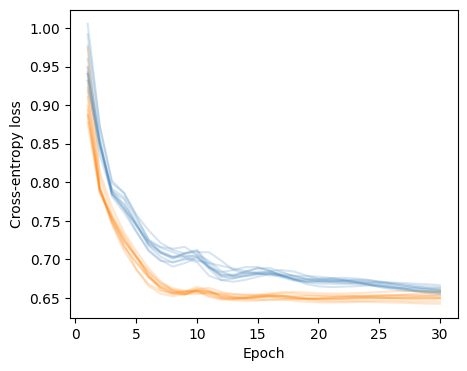

------------------------------ 
Training set:
Average log-likelihood = -4281.6 (23.2)
Average accuracy       = 74.7% (0.2%)
Average F1 score       = 71.9% (0.3%)
------------------------------ 
Validation set:
Average log-likelihood = -651.2 (4.8)
Average accuracy       = 73.9% (0.5%)
Average F1 score       = 70.8% (0.6%)
------------------------------ 
Test set:
Average log-likelihood = -1318.5 (108.7)
Average accuracy       = 78.9% (0.2%)
Average F1 score       = 72.5% (0.8%)
------------------------------ 
Training set:
Strong regularity = 0.985 (0.009)
Weak regularity   = 0.990 (0.007)
------------------------------ 
Validation set:
Strong regularity = 0.987 (0.006)
Weak regularity   = 0.991 (0.005)
------------------------------ 
Test set:
Strong regularity = 0.667 (0.170)
Weak regularity   = 0.868 (0.138)
------------------------------


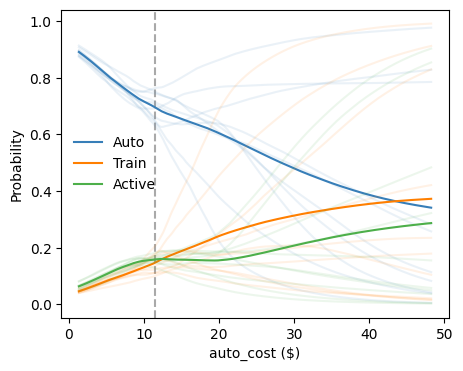

Penalty = 0.0001
------------------------------
Model 1 
Training set:   LL = -4272.9 | acc = 74.8% | F1 = 72.1%
Validation set: LL = -645.3  | acc = 73.9% | F1 = 70.8%
Test set:       LL = -1394.4 | acc = 79.0% | F1 = 73.1%
Model 2 
Training set:   LL = -4281.5 | acc = 74.3% | F1 = 71.5%
Validation set: LL = -655.7  | acc = 73.5% | F1 = 70.0%
Test set:       LL = -1609.4 | acc = 78.8% | F1 = 71.8%
Model 3 
Training set:   LL = -4282.3 | acc = 74.5% | F1 = 71.6%
Validation set: LL = -653.0  | acc = 73.9% | F1 = 70.6%
Test set:       LL = -1567.2 | acc = 79.1% | F1 = 71.9%
Model 4 
Training set:   LL = -4315.5 | acc = 74.3% | F1 = 71.5%
Validation set: LL = -659.0  | acc = 73.4% | F1 = 70.0%
Test set:       LL = -1229.8 | acc = 78.6% | F1 = 71.4%
Model 5 
Training set:   LL = -4276.3 | acc = 74.4% | F1 = 71.7%
Validation set: LL = -658.9  | acc = 73.4% | F1 = 70.1%
Test set:       LL = -1446.2 | acc = 79.2% | F1 = 72.3%
Model 6 
Training set:   LL = -4299.9 | acc = 74.7% | F1 = 71.9%
Va

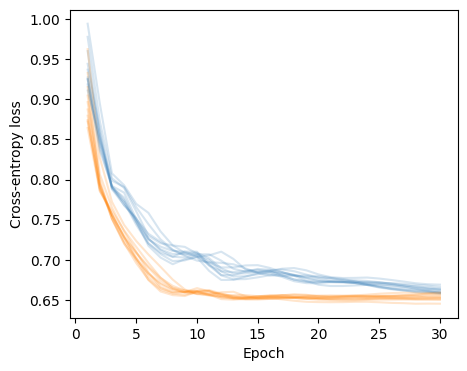

------------------------------ 
Training set:
Average log-likelihood = -4299.3 (24.2)
Average accuracy       = 74.5% (0.2%)
Average F1 score       = 71.6% (0.2%)
------------------------------ 
Validation set:
Average log-likelihood = -653.5 (4.0)
Average accuracy       = 73.7% (0.4%)
Average F1 score       = 70.3% (0.4%)
------------------------------ 
Test set:
Average log-likelihood = -1381.2 (137.5)
Average accuracy       = 79.0% (0.3%)
Average F1 score       = 72.2% (0.8%)
------------------------------ 
Training set:
Strong regularity = 0.950 (0.020)
Weak regularity   = 0.962 (0.017)
------------------------------ 
Validation set:
Strong regularity = 0.952 (0.015)
Weak regularity   = 0.963 (0.013)
------------------------------ 
Test set:
Strong regularity = 0.415 (0.189)
Weak regularity   = 0.661 (0.177)
------------------------------


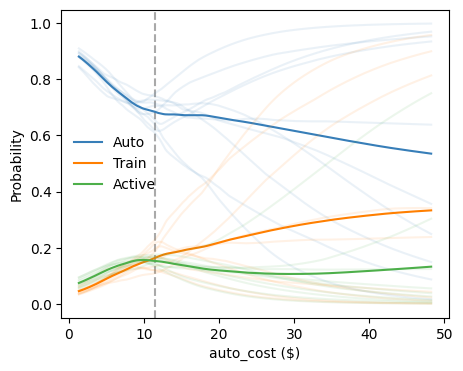

------------------------------ 
Model comparison:


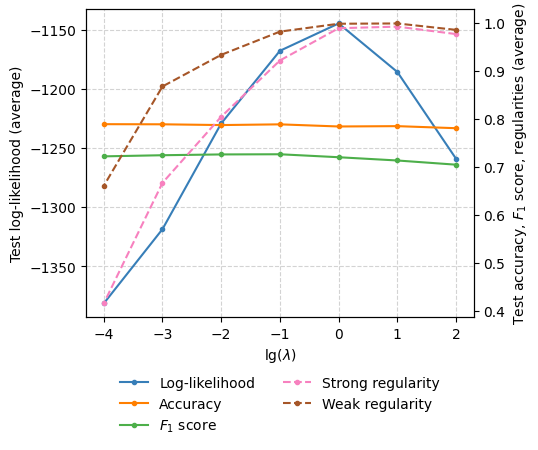

In [ ]:
# With sum
result(DNN, 30, 'UGR', [10**i for i in range(2, -5, -1)])

### LGR

Penalty = 100
------------------------------
Model 1 
Training set:   LL = -5054.2 | acc = 69.9% | F1 = 64.5%
Validation set: LL = -712.3  | acc = 69.9% | F1 = 64.3%
Test set:       LL = -1333.9 | acc = 75.2% | F1 = 70.7%
Model 2 
Training set:   LL = -5030.6 | acc = 68.5% | F1 = 60.1%
Validation set: LL = -709.6  | acc = 68.7% | F1 = 60.1%
Test set:       LL = -1302.6 | acc = 78.5% | F1 = 69.8%
Model 3 
Training set:   LL = -5035.5 | acc = 70.3% | F1 = 65.6%
Validation set: LL = -707.2  | acc = 70.7% | F1 = 66.1%
Test set:       LL = -1282.1 | acc = 77.4% | F1 = 70.5%
Model 4 
Training set:   LL = -5167.0 | acc = 69.6% | F1 = 66.3%
Validation set: LL = -734.0  | acc = 69.9% | F1 = 66.5%
Test set:       LL = -1601.3 | acc = 77.6% | F1 = 70.7%
Model 5 
Training set:   LL = -5156.8 | acc = 68.3% | F1 = 59.8%
Validation set: LL = -728.4  | acc = 68.5% | F1 = 59.9%
Test set:       LL = -1407.5 | acc = 77.7% | F1 = 70.7%
Model 6 
Training set:   LL = -5075.6 | acc = 70.1% | F1 = 63.8%
Valid

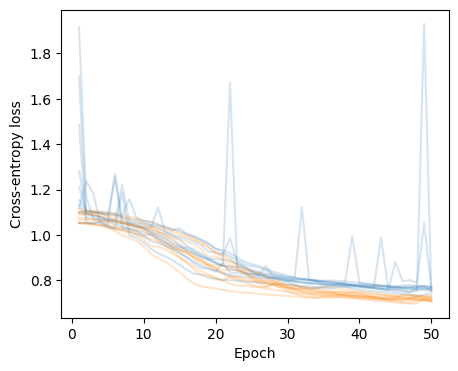

------------------------------ 
Training set:
Average log-likelihood = -5088.9 (55.6)
Average accuracy       = 69.3% (0.8%)
Average F1 score       = 62.8% (2.3%)
------------------------------ 
Validation set:
Average log-likelihood = -717.7 (9.1)
Average accuracy       = 69.5% (0.8%)
Average F1 score       = 62.8% (2.4%)
------------------------------ 
Test set:
Average log-likelihood = -1360.8 (88.8)
Average accuracy       = 77.6% (0.9%)
Average F1 score       = 70.5% (0.3%)
------------------------------ 
Training set:
Strong regularity = 1.000 (0.000)
Weak regularity   = 1.000 (0.000)
------------------------------ 
Validation set:
Strong regularity = 1.000 (0.000)
Weak regularity   = 1.000 (0.000)
------------------------------ 
Test set:
Strong regularity = 0.999 (0.003)
Weak regularity   = 1.000 (0.000)
------------------------------


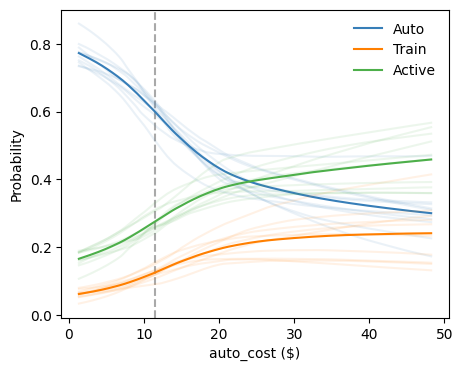

Penalty = 10
------------------------------
Model 1 
Training set:   LL = -4637.5 | acc = 72.3% | F1 = 68.4%
Validation set: LL = -661.9  | acc = 73.4% | F1 = 69.1%
Test set:       LL = -1225.9 | acc = 77.5% | F1 = 73.3%
Model 2 
Training set:   LL = -4647.2 | acc = 72.3% | F1 = 68.7%
Validation set: LL = -665.0  | acc = 73.8% | F1 = 70.4%
Test set:       LL = -1154.9 | acc = 78.9% | F1 = 72.3%
Model 3 
Training set:   LL = -4502.3 | acc = 73.4% | F1 = 70.9%
Validation set: LL = -648.8  | acc = 74.3% | F1 = 71.6%
Test set:       LL = -1142.2 | acc = 78.5% | F1 = 73.0%
Model 4 
Training set:   LL = -4692.8 | acc = 72.5% | F1 = 69.0%
Validation set: LL = -667.5  | acc = 74.2% | F1 = 70.7%
Test set:       LL = -1332.2 | acc = 78.5% | F1 = 71.1%
Model 5 
Training set:   LL = -4740.9 | acc = 71.7% | F1 = 67.7%
Validation set: LL = -675.0  | acc = 71.9% | F1 = 67.9%
Test set:       LL = -1371.4 | acc = 78.6% | F1 = 71.0%
Model 6 
Training set:   LL = -4828.8 | acc = 70.5% | F1 = 64.3%
Valida

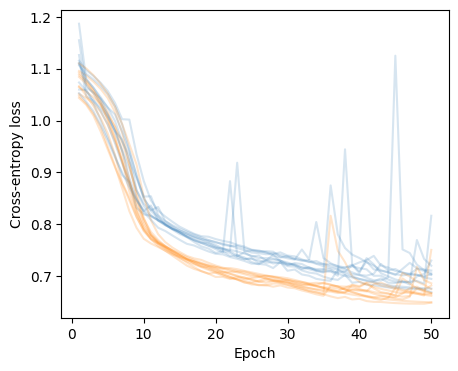

------------------------------ 
Training set:
Average log-likelihood = -4734.5 (195.7)
Average accuracy       = 71.5% (1.8%)
Average F1 score       = 67.1% (3.5%)
------------------------------ 
Validation set:
Average log-likelihood = -675.3 (27.6)
Average accuracy       = 72.4% (2.4%)
Average F1 score       = 68.0% (4.0%)
------------------------------ 
Test set:
Average log-likelihood = -1295.9 (119.8)
Average accuracy       = 78.3% (0.5%)
Average F1 score       = 72.0% (1.1%)
------------------------------ 
Training set:
Strong regularity = 0.999 (0.001)
Weak regularity   = 1.000 (0.000)
------------------------------ 
Validation set:
Strong regularity = 0.999 (0.001)
Weak regularity   = 1.000 (0.000)
------------------------------ 
Test set:
Strong regularity = 0.958 (0.031)
Weak regularity   = 1.000 (0.000)
------------------------------


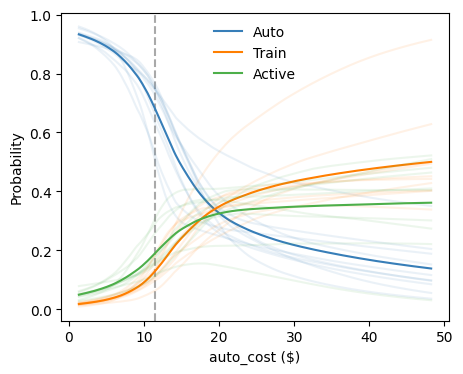

Penalty = 1
------------------------------
Model 1 
Training set:   LL = -4530.9 | acc = 72.9% | F1 = 69.3%
Validation set: LL = -654.5  | acc = 73.2% | F1 = 69.4%
Test set:       LL = -1166.2 | acc = 78.2% | F1 = 72.8%
Model 2 
Training set:   LL = -4493.1 | acc = 73.3% | F1 = 70.3%
Validation set: LL = -650.5  | acc = 73.8% | F1 = 70.6%
Test set:       LL = -1143.6 | acc = 78.8% | F1 = 72.9%
Model 3 
Training set:   LL = -4460.9 | acc = 73.3% | F1 = 70.2%
Validation set: LL = -647.0  | acc = 74.2% | F1 = 70.9%
Test set:       LL = -1203.9 | acc = 78.5% | F1 = 71.9%
Model 4 
Training set:   LL = -4529.3 | acc = 73.1% | F1 = 69.5%
Validation set: LL = -653.9  | acc = 73.7% | F1 = 70.2%
Test set:       LL = -1203.5 | acc = 78.7% | F1 = 71.7%
Model 5 
Training set:   LL = -4467.3 | acc = 73.5% | F1 = 70.5%
Validation set: LL = -647.2  | acc = 73.6% | F1 = 70.3%
Test set:       LL = -1158.7 | acc = 79.1% | F1 = 73.0%
Model 6 
Training set:   LL = -4474.9 | acc = 73.7% | F1 = 71.0%
Validat

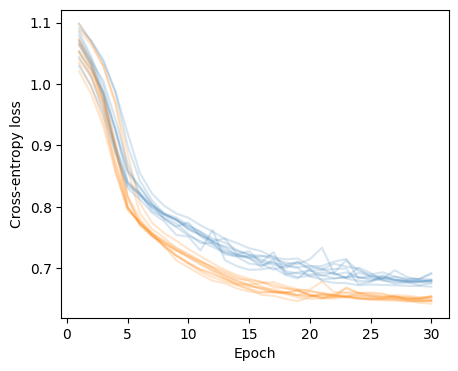

------------------------------ 
Training set:
Average log-likelihood = -4488.7 (24.6)
Average accuracy       = 73.3% (0.2%)
Average F1 score       = 70.2% (0.5%)
------------------------------ 
Validation set:
Average log-likelihood = -649.8 (3.9)
Average accuracy       = 73.8% (0.3%)
Average F1 score       = 70.6% (0.5%)
------------------------------ 
Test set:
Average log-likelihood = -1184.9 (31.9)
Average accuracy       = 78.7% (0.3%)
Average F1 score       = 72.5% (0.5%)
------------------------------ 
Training set:
Strong regularity = 0.999 (0.000)
Weak regularity   = 1.000 (0.000)
------------------------------ 
Validation set:
Strong regularity = 0.999 (0.001)
Weak regularity   = 1.000 (0.000)
------------------------------ 
Test set:
Strong regularity = 0.965 (0.012)
Weak regularity   = 1.000 (0.000)
------------------------------


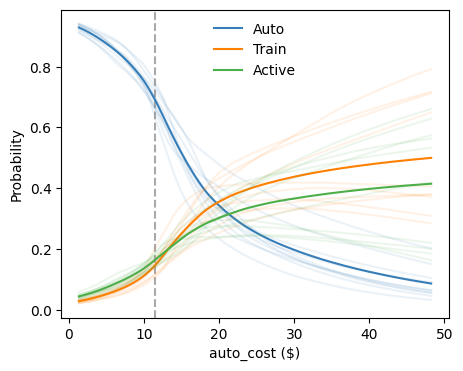

Penalty = 0.1
------------------------------
Model 1 
Training set:   LL = -4352.4 | acc = 74.1% | F1 = 71.2%
Validation set: LL = -643.8  | acc = 74.1% | F1 = 70.9%
Test set:       LL = -1164.3 | acc = 78.7% | F1 = 72.7%
Model 2 
Training set:   LL = -4348.3 | acc = 73.9% | F1 = 71.0%
Validation set: LL = -647.9  | acc = 73.7% | F1 = 70.1%
Test set:       LL = -1259.8 | acc = 79.0% | F1 = 73.0%
Model 3 
Training set:   LL = -4322.8 | acc = 74.3% | F1 = 71.3%
Validation set: LL = -647.6  | acc = 74.0% | F1 = 70.9%
Test set:       LL = -1243.9 | acc = 78.6% | F1 = 72.3%
Model 4 
Training set:   LL = -4385.7 | acc = 73.9% | F1 = 70.8%
Validation set: LL = -651.5  | acc = 73.7% | F1 = 70.3%
Test set:       LL = -1181.9 | acc = 79.0% | F1 = 72.1%
Model 5 
Training set:   LL = -4347.7 | acc = 74.0% | F1 = 71.2%
Validation set: LL = -643.6  | acc = 74.2% | F1 = 71.1%
Test set:       LL = -1336.5 | acc = 79.0% | F1 = 72.4%
Model 6 
Training set:   LL = -4361.3 | acc = 74.2% | F1 = 71.3%
Valid

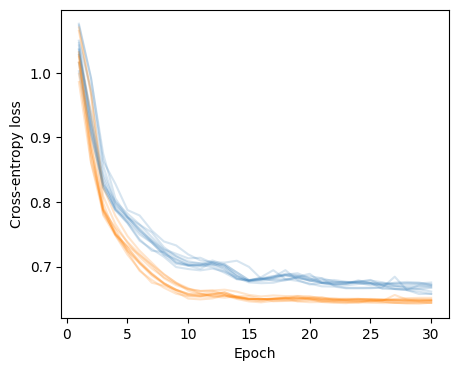

------------------------------ 
Training set:
Average log-likelihood = -4350.1 (20.8)
Average accuracy       = 74.1% (0.2%)
Average F1 score       = 71.3% (0.3%)
------------------------------ 
Validation set:
Average log-likelihood = -646.9 (2.4)
Average accuracy       = 73.9% (0.3%)
Average F1 score       = 70.7% (0.5%)
------------------------------ 
Test set:
Average log-likelihood = -1232.4 (54.9)
Average accuracy       = 78.8% (0.2%)
Average F1 score       = 72.4% (0.5%)
------------------------------ 
Training set:
Strong regularity = 0.998 (0.001)
Weak regularity   = 1.000 (0.000)
------------------------------ 
Validation set:
Strong regularity = 0.998 (0.001)
Weak regularity   = 1.000 (0.000)
------------------------------ 
Test set:
Strong regularity = 0.865 (0.071)
Weak regularity   = 0.977 (0.023)
------------------------------


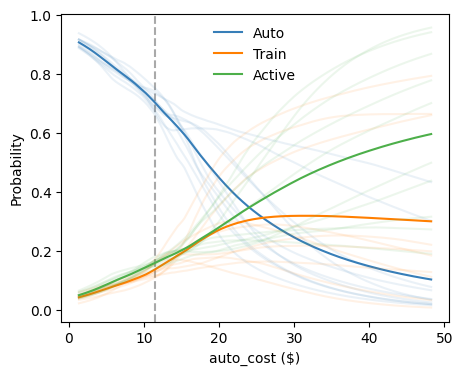

Penalty = 0.01
------------------------------
Model 1 
Training set:   LL = -4277.8 | acc = 74.9% | F1 = 72.2%
Validation set: LL = -645.1  | acc = 74.0% | F1 = 70.7%
Test set:       LL = -1248.7 | acc = 78.5% | F1 = 72.9%
Model 2 
Training set:   LL = -4251.8 | acc = 74.5% | F1 = 71.9%
Validation set: LL = -646.4  | acc = 74.0% | F1 = 71.0%
Test set:       LL = -1442.4 | acc = 78.7% | F1 = 72.6%
Model 3 
Training set:   LL = -4253.0 | acc = 74.8% | F1 = 72.1%
Validation set: LL = -650.7  | acc = 73.4% | F1 = 70.3%
Test set:       LL = -1251.0 | acc = 78.4% | F1 = 74.8%
Model 4 
Training set:   LL = -4319.7 | acc = 74.1% | F1 = 71.2%
Validation set: LL = -655.5  | acc = 73.2% | F1 = 69.9%
Test set:       LL = -1323.3 | acc = 78.5% | F1 = 71.1%
Model 5 
Training set:   LL = -4249.6 | acc = 74.9% | F1 = 72.3%
Validation set: LL = -653.7  | acc = 73.7% | F1 = 70.4%
Test set:       LL = -1580.3 | acc = 78.8% | F1 = 71.7%
Model 6 
Training set:   LL = -4284.0 | acc = 74.7% | F1 = 72.0%
Vali

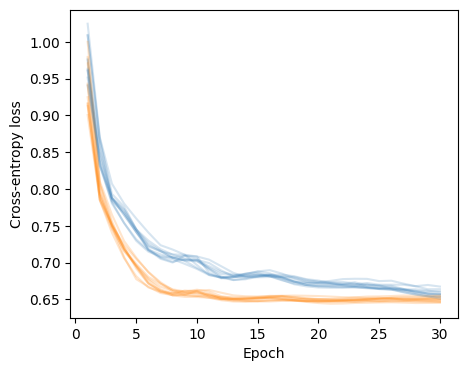

------------------------------ 
Training set:
Average log-likelihood = -4269.6 (25.2)
Average accuracy       = 74.7% (0.2%)
Average F1 score       = 72.0% (0.3%)
------------------------------ 
Validation set:
Average log-likelihood = -649.8 (3.2)
Average accuracy       = 73.9% (0.5%)
Average F1 score       = 70.7% (0.5%)
------------------------------ 
Test set:
Average log-likelihood = -1342.6 (102.8)
Average accuracy       = 78.6% (0.2%)
Average F1 score       = 72.6% (1.1%)
------------------------------ 
Training set:
Strong regularity = 0.994 (0.002)
Weak regularity   = 0.997 (0.001)
------------------------------ 
Validation set:
Strong regularity = 0.994 (0.003)
Weak regularity   = 0.997 (0.002)
------------------------------ 
Test set:
Strong regularity = 0.728 (0.136)
Weak regularity   = 0.921 (0.076)
------------------------------


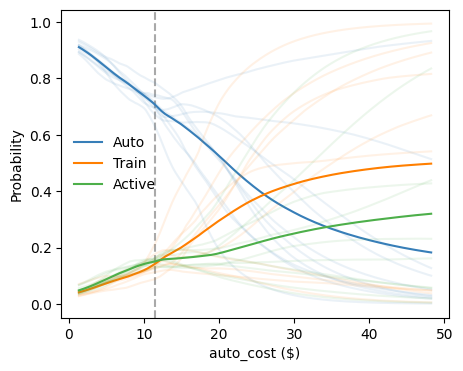

Penalty = 0.001
------------------------------
Model 1 
Training set:   LL = -4260.8 | acc = 74.8% | F1 = 72.2%
Validation set: LL = -646.1  | acc = 74.1% | F1 = 70.9%
Test set:       LL = -1335.4 | acc = 78.8% | F1 = 72.3%
Model 2 
Training set:   LL = -4267.1 | acc = 74.4% | F1 = 71.7%
Validation set: LL = -653.1  | acc = 73.5% | F1 = 70.1%
Test set:       LL = -1609.6 | acc = 78.9% | F1 = 72.4%
Model 3 
Training set:   LL = -4269.7 | acc = 74.7% | F1 = 71.9%
Validation set: LL = -650.5  | acc = 74.1% | F1 = 71.0%
Test set:       LL = -1507.4 | acc = 78.6% | F1 = 71.5%
Model 4 
Training set:   LL = -4285.7 | acc = 74.3% | F1 = 71.2%
Validation set: LL = -661.8  | acc = 73.6% | F1 = 70.0%
Test set:       LL = -1246.5 | acc = 78.8% | F1 = 71.5%
Model 5 
Training set:   LL = -4260.3 | acc = 74.6% | F1 = 71.9%
Validation set: LL = -656.9  | acc = 73.9% | F1 = 70.9%
Test set:       LL = -1470.4 | acc = 78.9% | F1 = 71.6%
Model 6 
Training set:   LL = -4289.1 | acc = 74.6% | F1 = 71.8%
Val

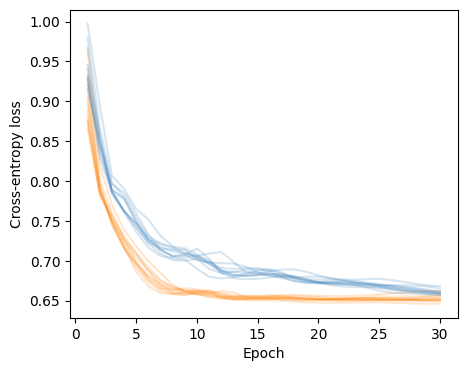

------------------------------ 
Training set:
Average log-likelihood = -4280.9 (20.8)
Average accuracy       = 74.6% (0.2%)
Average F1 score       = 71.8% (0.3%)
------------------------------ 
Validation set:
Average log-likelihood = -652.7 (4.2)
Average accuracy       = 73.8% (0.4%)
Average F1 score       = 70.5% (0.5%)
------------------------------ 
Test set:
Average log-likelihood = -1386.7 (116.3)
Average accuracy       = 78.8% (0.3%)
Average F1 score       = 71.9% (0.6%)
------------------------------ 
Training set:
Strong regularity = 0.969 (0.008)
Weak regularity   = 0.978 (0.006)
------------------------------ 
Validation set:
Strong regularity = 0.969 (0.009)
Weak regularity   = 0.977 (0.008)
------------------------------ 
Test set:
Strong regularity = 0.521 (0.152)
Weak regularity   = 0.760 (0.150)
------------------------------


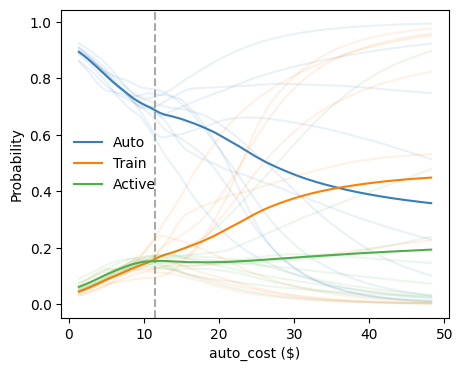

Penalty = 0.0001
------------------------------
Model 1 
Training set:   LL = -4284.2 | acc = 74.5% | F1 = 71.7%
Validation set: LL = -647.8  | acc = 73.6% | F1 = 70.1%
Test set:       LL = -1315.8 | acc = 78.8% | F1 = 73.1%
Model 2 
Training set:   LL = -4266.7 | acc = 74.3% | F1 = 71.5%
Validation set: LL = -660.2  | acc = 73.3% | F1 = 69.7%
Test set:       LL = -1648.5 | acc = 79.1% | F1 = 71.7%
Model 3 
Training set:   LL = -4297.2 | acc = 74.3% | F1 = 71.4%
Validation set: LL = -656.1  | acc = 73.8% | F1 = 70.5%
Test set:       LL = -1568.1 | acc = 79.1% | F1 = 72.1%
Model 4 
Training set:   LL = -4284.6 | acc = 74.3% | F1 = 71.5%
Validation set: LL = -661.8  | acc = 73.6% | F1 = 70.4%
Test set:       LL = -1214.8 | acc = 78.6% | F1 = 71.4%
Model 5 
Training set:   LL = -4279.4 | acc = 74.6% | F1 = 71.7%
Validation set: LL = -658.7  | acc = 73.7% | F1 = 70.4%
Test set:       LL = -1474.8 | acc = 79.1% | F1 = 71.6%
Model 6 
Training set:   LL = -4283.0 | acc = 74.8% | F1 = 72.1%
Va

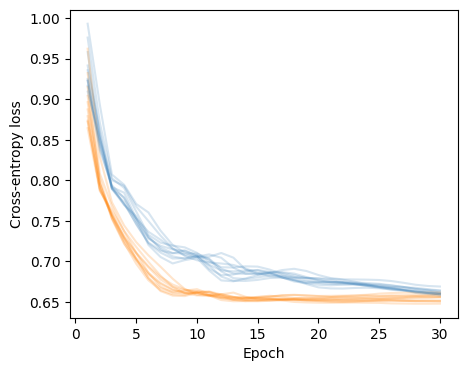

------------------------------ 
Training set:
Average log-likelihood = -4292.8 (25.1)
Average accuracy       = 74.4% (0.2%)
Average F1 score       = 71.6% (0.3%)
------------------------------ 
Validation set:
Average log-likelihood = -655.0 (4.3)
Average accuracy       = 73.6% (0.4%)
Average F1 score       = 70.2% (0.5%)
------------------------------ 
Test set:
Average log-likelihood = -1354.5 (156.8)
Average accuracy       = 78.8% (0.6%)
Average F1 score       = 72.5% (1.1%)
------------------------------ 
Training set:
Strong regularity = 0.916 (0.032)
Weak regularity   = 0.930 (0.030)
------------------------------ 
Validation set:
Strong regularity = 0.919 (0.031)
Weak regularity   = 0.931 (0.028)
------------------------------ 
Test set:
Strong regularity = 0.376 (0.242)
Weak regularity   = 0.565 (0.226)
------------------------------


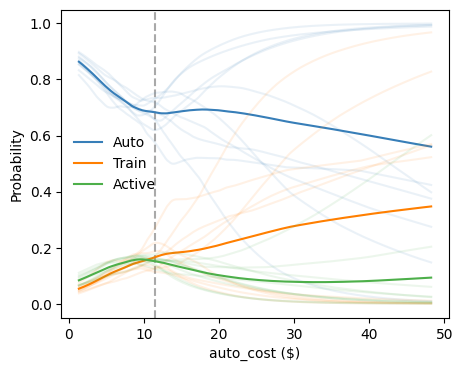

------------------------------ 
Model comparison:


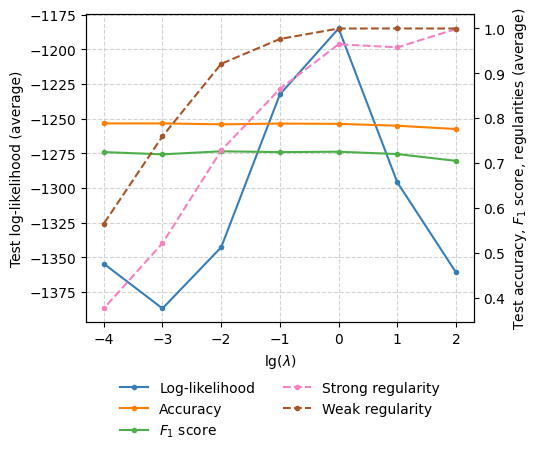

In [ ]:
# With sum
result(DNN, 30, 'LGR', [10**i for i in range(2, -5, -1)])

## TasteNet
A flexible NN-based choice model proposed by [Han et al. (2022)](https://doi.org/10.1016/j.trb.2022.07.001). Here is a special case that learns all $\beta$'s from TasteNet.

In [ ]:
class TasteNet(nn.Module):
    'Class of TasteNet'
    def __init__(self):
        super(TasteNet, self).__init__()
        self.seq = nn.Sequential(
            nn.Linear(8, 100),
            nn.ReLU(),
            nn.Linear(100, 7)
        )

    def forward(self, x):
        'Function to specify utilities using TasteNet parameters'
        betas = self.seq(x[:, :8])
        V1 = betas[:, 0] * torch.ones(len(x)) + torch.sum(betas[:, 1:3] * x[:, 8:10], dim=1)
        V2 = betas[:, 3] * torch.ones(len(x)) + torch.sum(betas[:, 4:6] * x[:, 10:12], dim=1)
        V3 = betas[:, 6] * x[:, 12]
        return torch.stack((V1, V2, V3), dim=1)

### Without GR

Penalty = 0
------------------------------
Model 1 
Training set:   LL = -4595.7 | acc = 72.6% | F1 = 69.0%
Validation set: LL = -661.0  | acc = 74.4% | F1 = 70.8%
Test set:       LL = -2088.6 | acc = 68.5% | F1 = 69.5%
Model 2 
Training set:   LL = -4598.8 | acc = 72.6% | F1 = 69.0%
Validation set: LL = -662.8  | acc = 74.5% | F1 = 70.7%
Test set:       LL = -2021.3 | acc = 69.8% | F1 = 70.4%
Model 3 
Training set:   LL = -4595.0 | acc = 72.6% | F1 = 69.1%
Validation set: LL = -663.8  | acc = 74.3% | F1 = 70.4%
Test set:       LL = -2094.3 | acc = 68.9% | F1 = 69.8%
Model 4 
Training set:   LL = -4583.6 | acc = 72.6% | F1 = 69.2%
Validation set: LL = -658.5  | acc = 74.4% | F1 = 70.8%
Test set:       LL = -2176.7 | acc = 67.0% | F1 = 68.3%
Model 5 
Training set:   LL = -4589.0 | acc = 72.7% | F1 = 69.3%
Validation set: LL = -660.6  | acc = 74.5% | F1 = 70.8%
Test set:       LL = -2072.7 | acc = 69.1% | F1 = 69.8%
Model 6 
Training set:   LL = -4581.3 | acc = 72.7% | F1 = 69.3%
Validat

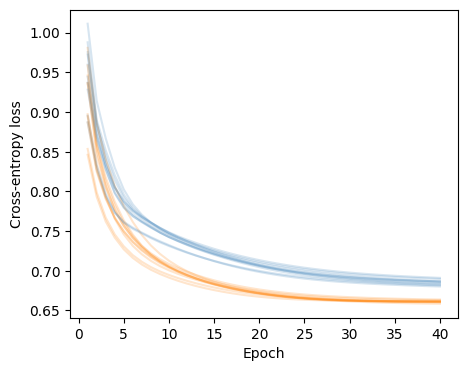

------------------------------ 
Training set:
Average log-likelihood = -4588.5 (11.2)
Average accuracy       = 72.7% (0.1%)
Average F1 score       = 69.2% (0.1%)
------------------------------ 
Validation set:
Average log-likelihood = -661.2 (1.4)
Average accuracy       = 74.4% (0.2%)
Average F1 score       = 70.8% (0.3%)
------------------------------ 
Test set:
Average log-likelihood = -2138.9 (71.6)
Average accuracy       = 67.7% (1.4%)
Average F1 score       = 68.8% (1.0%)
------------------------------ 
Training set:
Strong regularity = 0.999 (0.001)
Weak regularity   = 0.999 (0.001)
------------------------------ 
Validation set:
Strong regularity = 1.000 (0.001)
Weak regularity   = 1.000 (0.001)
------------------------------ 
Test set:
Strong regularity = 0.983 (0.004)
Weak regularity   = 1.000 (0.001)
------------------------------


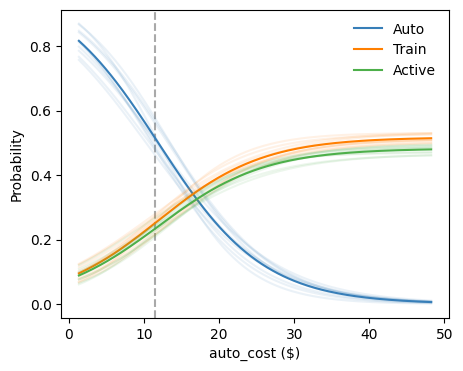

In [ ]:
result(TasteNet, 40, 'none')

### PGR

Penalty = 10
------------------------------
Model 1 
Training set:   LL = -7091.7 | acc = 54.0% | F1 = 50.3%
Validation set: LL = -1001.9 | acc = 53.6% | F1 = 50.1%
Test set:       LL = -2529.0 | acc = 27.0% | F1 = 31.1%
Model 2 
Training set:   LL = -6042.4 | acc = 61.9% | F1 = 55.3%
Validation set: LL = -854.8  | acc = 63.1% | F1 = 56.0%
Test set:       LL = -2131.6 | acc = 35.6% | F1 = 43.9%
Model 3 
Training set:   LL = -8174.6 | acc = 34.2% | F1 = 36.6%
Validation set: LL = -1181.0 | acc = 32.8% | F1 = 35.1%
Test set:       LL = -3150.9 | acc = 11.2% | F1 = 6.3%
Model 4 
Training set:   LL = -5868.4 | acc = 66.0% | F1 = 53.5%
Validation set: LL = -838.7  | acc = 66.5% | F1 = 53.7%
Test set:       LL = -1841.7 | acc = 60.0% | F1 = 62.2%
Model 5 
Training set:   LL = -5597.3 | acc = 65.4% | F1 = 55.1%
Validation set: LL = -793.2  | acc = 64.8% | F1 = 54.6%
Test set:       LL = -2335.0 | acc = 29.9% | F1 = 36.9%
Model 6 
Training set:   LL = -6206.6 | acc = 62.0% | F1 = 53.4%
Validat

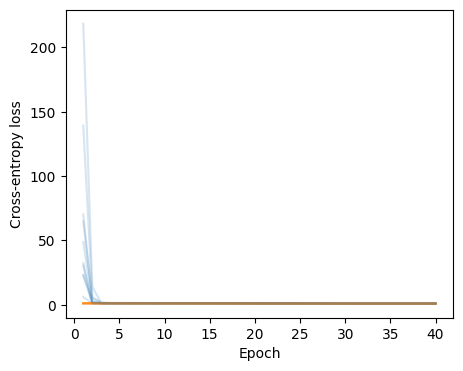

------------------------------ 
Training set:
Average log-likelihood = -6367.0 (733.1)
Average accuracy       = 59.0% (9.6%)
Average F1 score       = 52.3% (5.4%)
------------------------------ 
Validation set:
Average log-likelihood = -906.5 (109.4)
Average accuracy       = 59.1% (10.2%)
Average F1 score       = 52.2% (5.9%)
------------------------------ 
Test set:
Average log-likelihood = -2374.2 (408.3)
Average accuracy       = 32.7% (14.7%)
Average F1 score       = 36.8% (16.4%)
------------------------------ 
Training set:
Strong regularity = 1.000 (0.000)
Weak regularity   = 1.000 (0.000)
------------------------------ 
Validation set:
Strong regularity = 1.000 (0.000)
Weak regularity   = 1.000 (0.000)
------------------------------ 
Test set:
Strong regularity = 1.000 (0.000)
Weak regularity   = 1.000 (0.000)
------------------------------


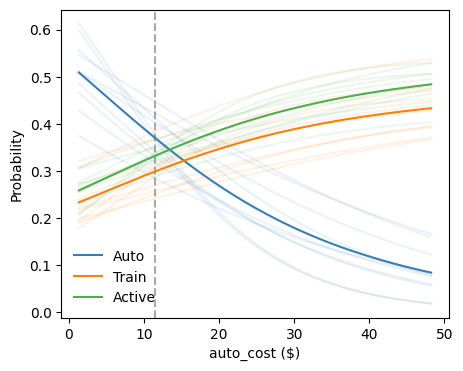

Penalty = 1
------------------------------
Model 1 
Training set:   LL = -5571.0 | acc = 67.4% | F1 = 56.4%
Validation set: LL = -787.3  | acc = 68.1% | F1 = 58.0%
Test set:       LL = -1791.0 | acc = 62.7% | F1 = 64.3%
Model 2 
Training set:   LL = -5240.2 | acc = 69.0% | F1 = 60.7%
Validation set: LL = -734.4  | acc = 69.0% | F1 = 60.9%
Test set:       LL = -1485.0 | acc = 74.4% | F1 = 68.5%
Model 3 
Training set:   LL = -6197.4 | acc = 61.8% | F1 = 53.2%
Validation set: LL = -895.9  | acc = 61.6% | F1 = 52.9%
Test set:       LL = -2452.3 | acc = 15.8% | F1 = 16.5%
Model 4 
Training set:   LL = -5303.4 | acc = 67.5% | F1 = 56.0%
Validation set: LL = -748.5  | acc = 69.2% | F1 = 59.0%
Test set:       LL = -1544.6 | acc = 76.2% | F1 = 68.8%
Model 5 
Training set:   LL = -5156.8 | acc = 70.0% | F1 = 63.7%
Validation set: LL = -732.2  | acc = 69.8% | F1 = 63.5%
Test set:       LL = -1487.7 | acc = 77.8% | F1 = 70.1%
Model 6 
Training set:   LL = -5456.8 | acc = 66.7% | F1 = 54.8%
Validat

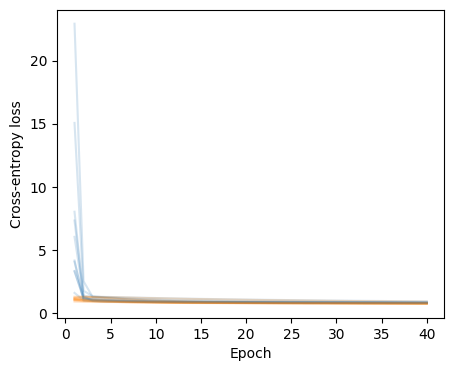

------------------------------ 
Training set:
Average log-likelihood = -5448.3 (275.7)
Average accuracy       = 67.4% (2.2%)
Average F1 score       = 57.6% (3.8%)
------------------------------ 
Validation set:
Average log-likelihood = -772.6 (44.5)
Average accuracy       = 67.7% (2.4%)
Average F1 score       = 58.1% (4.0%)
------------------------------ 
Test set:
Average log-likelihood = -1765.4 (300.4)
Average accuracy       = 61.9% (19.3%)
Average F1 score       = 59.6% (16.4%)
------------------------------ 
Training set:
Strong regularity = 1.000 (0.000)
Weak regularity   = 1.000 (0.000)
------------------------------ 
Validation set:
Strong regularity = 1.000 (0.000)
Weak regularity   = 1.000 (0.000)
------------------------------ 
Test set:
Strong regularity = 1.000 (0.000)
Weak regularity   = 1.000 (0.000)
------------------------------


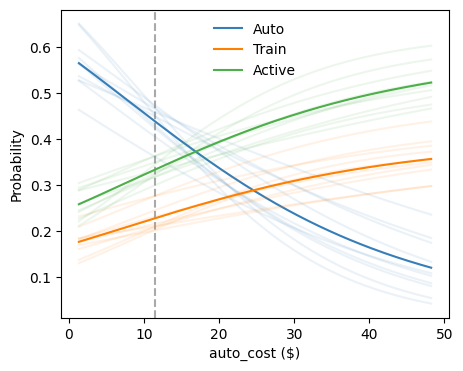

Penalty = 0.1
------------------------------
Model 1 
Training set:   LL = -5112.6 | acc = 70.5% | F1 = 64.3%
Validation set: LL = -720.0  | acc = 71.0% | F1 = 64.8%
Test set:       LL = -1416.2 | acc = 76.6% | F1 = 69.3%
Model 2 
Training set:   LL = -4896.1 | acc = 71.2% | F1 = 65.6%
Validation set: LL = -683.7  | acc = 71.6% | F1 = 66.2%
Test set:       LL = -1323.5 | acc = 78.6% | F1 = 70.1%
Model 3 
Training set:   LL = -5132.4 | acc = 70.0% | F1 = 64.0%
Validation set: LL = -725.8  | acc = 70.5% | F1 = 64.4%
Test set:       LL = -1463.7 | acc = 76.8% | F1 = 70.8%
Model 4 
Training set:   LL = -5007.4 | acc = 70.6% | F1 = 65.1%
Validation set: LL = -697.7  | acc = 71.7% | F1 = 65.9%
Test set:       LL = -1323.4 | acc = 78.4% | F1 = 69.1%
Model 5 
Training set:   LL = -4935.6 | acc = 71.0% | F1 = 65.5%
Validation set: LL = -694.8  | acc = 71.4% | F1 = 66.0%
Test set:       LL = -1329.6 | acc = 79.0% | F1 = 70.6%
Model 6 
Training set:   LL = -5075.0 | acc = 70.4% | F1 = 64.6%
Valid

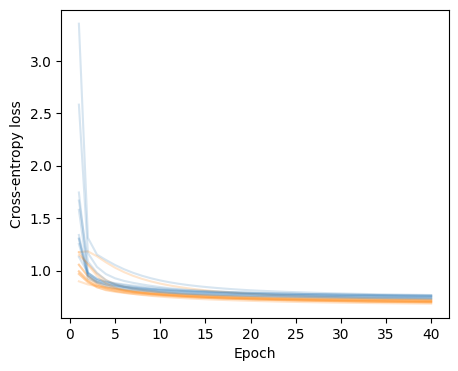

------------------------------ 
Training set:
Average log-likelihood = -5029.3 (75.6)
Average accuracy       = 70.6% (0.4%)
Average F1 score       = 64.8% (0.6%)
------------------------------ 
Validation set:
Average log-likelihood = -705.6 (12.0)
Average accuracy       = 71.3% (0.4%)
Average F1 score       = 65.4% (0.7%)
------------------------------ 
Test set:
Average log-likelihood = -1348.0 (52.0)
Average accuracy       = 78.2% (0.7%)
Average F1 score       = 69.8% (0.6%)
------------------------------ 
Training set:
Strong regularity = 0.999 (0.003)
Weak regularity   = 1.000 (0.000)
------------------------------ 
Validation set:
Strong regularity = 0.999 (0.003)
Weak regularity   = 1.000 (0.000)
------------------------------ 
Test set:
Strong regularity = 0.998 (0.003)
Weak regularity   = 1.000 (0.000)
------------------------------


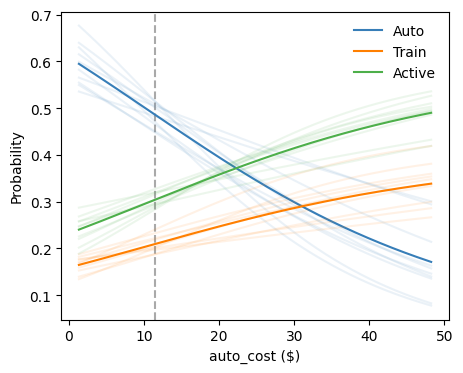

Penalty = 0.01
------------------------------
Model 1 
Training set:   LL = -4829.8 | acc = 71.7% | F1 = 66.7%
Validation set: LL = -678.1  | acc = 72.7% | F1 = 67.7%
Test set:       LL = -1295.5 | acc = 78.8% | F1 = 71.6%
Model 2 
Training set:   LL = -4657.7 | acc = 72.2% | F1 = 68.3%
Validation set: LL = -662.2  | acc = 75.0% | F1 = 71.1%
Test set:       LL = -1689.6 | acc = 75.0% | F1 = 73.4%
Model 3 
Training set:   LL = -4808.2 | acc = 71.8% | F1 = 66.9%
Validation set: LL = -678.8  | acc = 72.4% | F1 = 67.4%
Test set:       LL = -1342.9 | acc = 78.5% | F1 = 72.6%
Model 4 
Training set:   LL = -4708.8 | acc = 72.3% | F1 = 68.1%
Validation set: LL = -664.6  | acc = 74.9% | F1 = 70.6%
Test set:       LL = -1512.6 | acc = 76.2% | F1 = 72.9%
Model 5 
Training set:   LL = -4665.1 | acc = 72.2% | F1 = 68.3%
Validation set: LL = -664.2  | acc = 73.9% | F1 = 70.0%
Test set:       LL = -1548.2 | acc = 76.7% | F1 = 73.5%
Model 6 
Training set:   LL = -4776.5 | acc = 72.0% | F1 = 67.4%
Vali

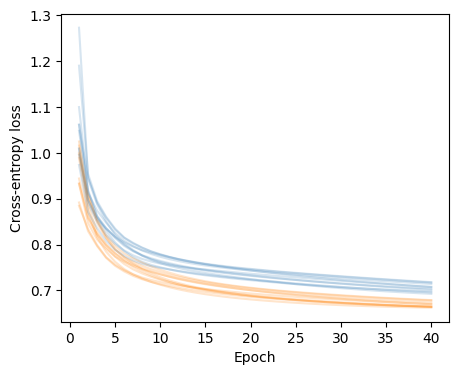

------------------------------ 
Training set:
Average log-likelihood = -4736.6 (55.5)
Average accuracy       = 72.0% (0.2%)
Average F1 score       = 67.6% (0.6%)
------------------------------ 
Validation set:
Average log-likelihood = -669.0 (5.7)
Average accuracy       = 73.7% (0.9%)
Average F1 score       = 69.3% (1.3%)
------------------------------ 
Test set:
Average log-likelihood = -1457.5 (117.6)
Average accuracy       = 77.1% (1.2%)
Average F1 score       = 72.8% (0.6%)
------------------------------ 
Training set:
Strong regularity = 1.000 (0.001)
Weak regularity   = 1.000 (0.000)
------------------------------ 
Validation set:
Strong regularity = 1.000 (0.000)
Weak regularity   = 1.000 (0.000)
------------------------------ 
Test set:
Strong regularity = 0.993 (0.003)
Weak regularity   = 1.000 (0.000)
------------------------------


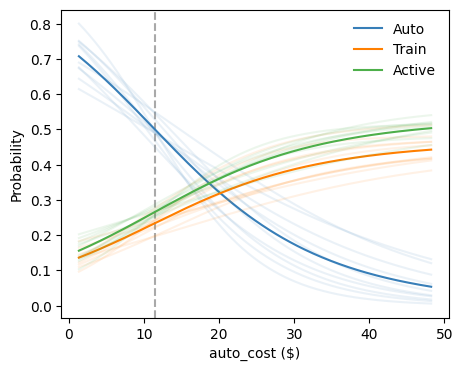

Penalty = 0.001
------------------------------
Model 1 
Training set:   LL = -4612.6 | acc = 72.4% | F1 = 68.7%
Validation set: LL = -659.9  | acc = 74.3% | F1 = 70.4%
Test set:       LL = -1773.6 | acc = 74.0% | F1 = 73.1%
Model 2 
Training set:   LL = -4606.1 | acc = 72.6% | F1 = 69.1%
Validation set: LL = -661.4  | acc = 74.7% | F1 = 71.1%
Test set:       LL = -1865.8 | acc = 72.8% | F1 = 72.3%
Model 3 
Training set:   LL = -4607.9 | acc = 72.5% | F1 = 69.0%
Validation set: LL = -663.0  | acc = 74.1% | F1 = 70.3%
Test set:       LL = -1847.1 | acc = 73.5% | F1 = 72.6%
Model 4 
Training set:   LL = -4593.5 | acc = 72.6% | F1 = 69.1%
Validation set: LL = -658.9  | acc = 74.4% | F1 = 70.9%
Test set:       LL = -1946.1 | acc = 71.9% | F1 = 71.7%
Model 5 
Training set:   LL = -4596.0 | acc = 72.7% | F1 = 69.2%
Validation set: LL = -660.0  | acc = 74.7% | F1 = 71.1%
Test set:       LL = -1872.9 | acc = 73.4% | F1 = 72.7%
Model 6 
Training set:   LL = -4598.6 | acc = 72.7% | F1 = 69.1%
Val

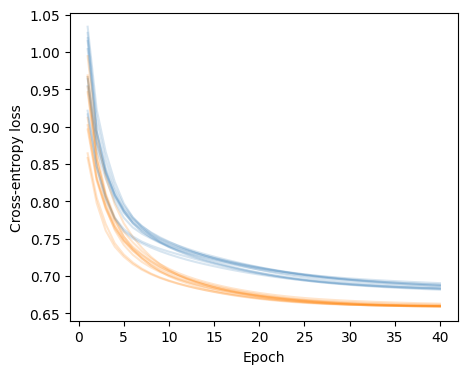

------------------------------ 
Training set:
Average log-likelihood = -4600.0 (9.3)
Average accuracy       = 72.6% (0.1%)
Average F1 score       = 69.1% (0.2%)
------------------------------ 
Validation set:
Average log-likelihood = -660.1 (1.2)
Average accuracy       = 74.5% (0.3%)
Average F1 score       = 70.9% (0.4%)
------------------------------ 
Test set:
Average log-likelihood = -1873.7 (45.5)
Average accuracy       = 72.7% (0.8%)
Average F1 score       = 72.1% (0.5%)
------------------------------ 
Training set:
Strong regularity = 0.999 (0.001)
Weak regularity   = 1.000 (0.001)
------------------------------ 
Validation set:
Strong regularity = 1.000 (0.001)
Weak regularity   = 1.000 (0.001)
------------------------------ 
Test set:
Strong regularity = 0.980 (0.004)
Weak regularity   = 1.000 (0.000)
------------------------------


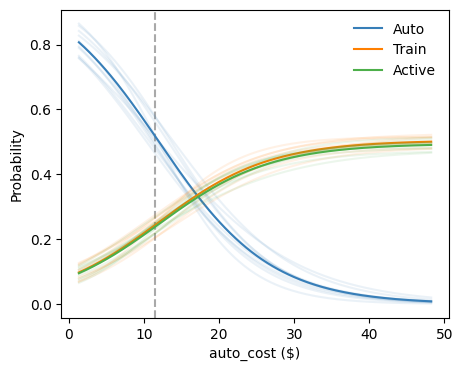

Penalty = 0.0001
------------------------------
Model 1 
Training set:   LL = -4597.5 | acc = 72.5% | F1 = 69.0%
Validation set: LL = -660.0  | acc = 74.5% | F1 = 70.9%
Test set:       LL = -1962.2 | acc = 70.9% | F1 = 71.0%
Model 2 
Training set:   LL = -4600.2 | acc = 72.6% | F1 = 69.1%
Validation set: LL = -662.1  | acc = 74.7% | F1 = 71.0%
Test set:       LL = -1928.9 | acc = 71.8% | F1 = 71.7%
Model 3 
Training set:   LL = -4595.1 | acc = 72.6% | F1 = 69.1%
Validation set: LL = -663.0  | acc = 74.4% | F1 = 70.5%
Test set:       LL = -1988.0 | acc = 70.8% | F1 = 71.0%
Model 4 
Training set:   LL = -4585.6 | acc = 72.6% | F1 = 69.2%
Validation set: LL = -658.1  | acc = 74.5% | F1 = 71.1%
Test set:       LL = -2062.1 | acc = 69.5% | F1 = 70.1%
Model 5 
Training set:   LL = -4589.7 | acc = 72.7% | F1 = 69.2%
Validation set: LL = -659.6  | acc = 74.7% | F1 = 71.1%
Test set:       LL = -1964.9 | acc = 71.2% | F1 = 71.2%
Model 6 
Training set:   LL = -4583.6 | acc = 72.8% | F1 = 69.4%
Va

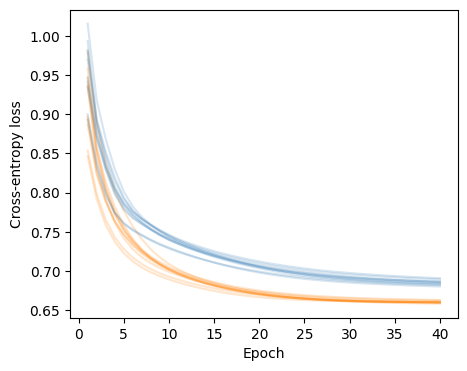

------------------------------ 
Training set:
Average log-likelihood = -4590.0 (10.8)
Average accuracy       = 72.7% (0.1%)
Average F1 score       = 69.2% (0.1%)
------------------------------ 
Validation set:
Average log-likelihood = -660.3 (1.3)
Average accuracy       = 74.5% (0.2%)
Average F1 score       = 70.9% (0.3%)
------------------------------ 
Test set:
Average log-likelihood = -2012.9 (51.4)
Average accuracy       = 70.3% (0.9%)
Average F1 score       = 70.6% (0.6%)
------------------------------ 
Training set:
Strong regularity = 0.999 (0.001)
Weak regularity   = 0.999 (0.001)
------------------------------ 
Validation set:
Strong regularity = 1.000 (0.001)
Weak regularity   = 1.000 (0.001)
------------------------------ 
Test set:
Strong regularity = 0.981 (0.004)
Weak regularity   = 1.000 (0.000)
------------------------------


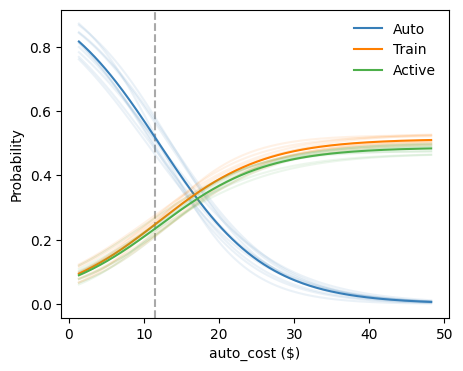

Penalty = 1e-05
------------------------------
Model 1 
Training set:   LL = -4595.7 | acc = 72.6% | F1 = 69.0%
Validation set: LL = -660.8  | acc = 74.4% | F1 = 70.8%
Test set:       LL = -2069.2 | acc = 68.8% | F1 = 69.7%
Model 2 
Training set:   LL = -4598.9 | acc = 72.6% | F1 = 69.0%
Validation set: LL = -662.7  | acc = 74.6% | F1 = 70.9%
Test set:       LL = -2006.8 | acc = 70.0% | F1 = 70.5%
Model 3 
Training set:   LL = -4594.9 | acc = 72.6% | F1 = 69.1%
Validation set: LL = -663.7  | acc = 74.3% | F1 = 70.4%
Test set:       LL = -2078.3 | acc = 69.3% | F1 = 70.0%
Model 4 
Training set:   LL = -4583.8 | acc = 72.6% | F1 = 69.2%
Validation set: LL = -658.4  | acc = 74.5% | F1 = 71.0%
Test set:       LL = -2158.2 | acc = 67.5% | F1 = 68.7%
Model 5 
Training set:   LL = -4589.0 | acc = 72.7% | F1 = 69.3%
Validation set: LL = -660.4  | acc = 74.5% | F1 = 70.8%
Test set:       LL = -2056.6 | acc = 69.5% | F1 = 70.0%
Model 6 
Training set:   LL = -4581.4 | acc = 72.8% | F1 = 69.3%
Val

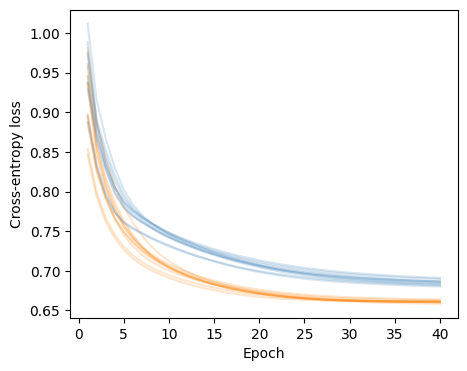

------------------------------ 
Training set:
Average log-likelihood = -4588.6 (11.2)
Average accuracy       = 72.7% (0.1%)
Average F1 score       = 69.2% (0.1%)
------------------------------ 
Validation set:
Average log-likelihood = -661.1 (1.4)
Average accuracy       = 74.5% (0.2%)
Average F1 score       = 70.8% (0.3%)
------------------------------ 
Test set:
Average log-likelihood = -2120.0 (68.9)
Average accuracy       = 68.1% (1.3%)
Average F1 score       = 69.1% (1.0%)
------------------------------ 
Training set:
Strong regularity = 0.999 (0.001)
Weak regularity   = 0.999 (0.001)
------------------------------ 
Validation set:
Strong regularity = 1.000 (0.001)
Weak regularity   = 1.000 (0.001)
------------------------------ 
Test set:
Strong regularity = 0.983 (0.004)
Weak regularity   = 1.000 (0.001)
------------------------------


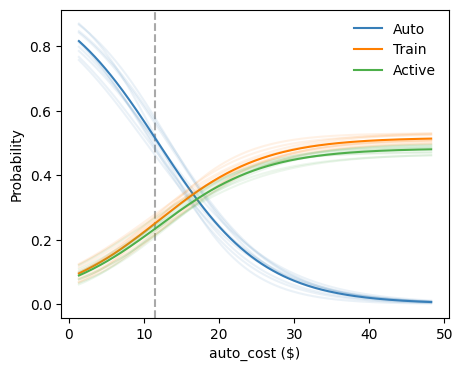

------------------------------ 
Model comparison:


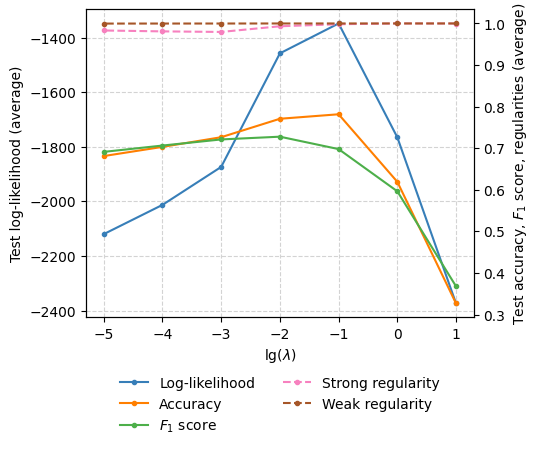

In [ ]:
result(TasteNet, 40, 'PGR', [10**i for i in range(1, -6, -1)])

### UGR

Penalty = 10
------------------------------
Model 1 
Training set:   LL = -5344.7 | acc = 67.9% | F1 = 61.4%
Validation set: LL = -752.5  | acc = 68.0% | F1 = 61.0%
Test set:       LL = -2009.2 | acc = 51.8% | F1 = 56.1%
Model 2 
Training set:   LL = -5199.1 | acc = 69.2% | F1 = 63.1%
Validation set: LL = -727.3  | acc = 69.6% | F1 = 63.7%
Test set:       LL = -1580.5 | acc = 69.1% | F1 = 68.2%
Model 3 
Training set:   LL = -5319.0 | acc = 67.8% | F1 = 62.0%
Validation set: LL = -750.4  | acc = 68.1% | F1 = 61.6%
Test set:       LL = -1928.4 | acc = 57.2% | F1 = 60.2%
Model 4 
Training set:   LL = -5202.2 | acc = 69.1% | F1 = 63.1%
Validation set: LL = -723.1  | acc = 70.1% | F1 = 63.9%
Test set:       LL = -1557.6 | acc = 72.5% | F1 = 69.5%
Model 5 
Training set:   LL = -5207.4 | acc = 69.2% | F1 = 63.1%
Validation set: LL = -741.8  | acc = 69.5% | F1 = 63.2%
Test set:       LL = -1638.7 | acc = 69.2% | F1 = 67.6%
Model 6 
Training set:   LL = -5250.1 | acc = 68.4% | F1 = 62.1%
Valida

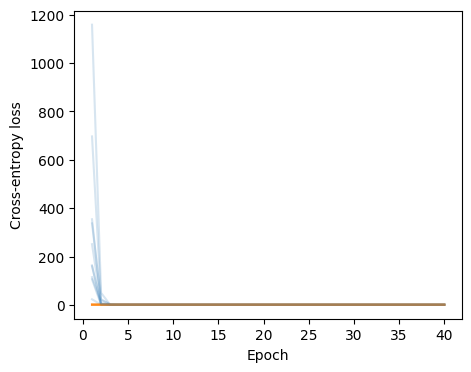

------------------------------ 
Training set:
Average log-likelihood = -5254.7 (48.3)
Average accuracy       = 68.7% (0.6%)
Average F1 score       = 62.6% (0.7%)
------------------------------ 
Validation set:
Average log-likelihood = -738.9 (8.5)
Average accuracy       = 69.3% (0.7%)
Average F1 score       = 62.8% (0.9%)
------------------------------ 
Test set:
Average log-likelihood = -1741.1 (140.3)
Average accuracy       = 63.7% (6.4%)
Average F1 score       = 64.2% (4.2%)
------------------------------ 
Training set:
Strong regularity = 1.000 (0.000)
Weak regularity   = 1.000 (0.000)
------------------------------ 
Validation set:
Strong regularity = 1.000 (0.000)
Weak regularity   = 1.000 (0.000)
------------------------------ 
Test set:
Strong regularity = 1.000 (0.000)
Weak regularity   = 1.000 (0.000)
------------------------------


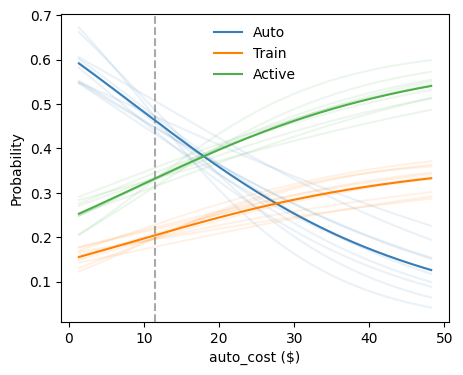

Penalty = 1
------------------------------
Model 1 
Training set:   LL = -5313.5 | acc = 68.2% | F1 = 61.8%
Validation set: LL = -748.3  | acc = 68.4% | F1 = 61.5%
Test set:       LL = -1928.0 | acc = 54.6% | F1 = 58.2%
Model 2 
Training set:   LL = -5157.4 | acc = 69.7% | F1 = 63.8%
Validation set: LL = -721.8  | acc = 69.8% | F1 = 63.8%
Test set:       LL = -1479.6 | acc = 72.9% | F1 = 70.2%
Model 3 
Training set:   LL = -5308.7 | acc = 68.0% | F1 = 62.2%
Validation set: LL = -748.8  | acc = 68.2% | F1 = 61.8%
Test set:       LL = -1895.8 | acc = 58.1% | F1 = 60.8%
Model 4 
Training set:   LL = -5185.9 | acc = 69.1% | F1 = 63.2%
Validation set: LL = -721.2  | acc = 70.2% | F1 = 63.8%
Test set:       LL = -1504.7 | acc = 75.3% | F1 = 70.8%
Model 5 
Training set:   LL = -5162.7 | acc = 69.9% | F1 = 63.7%
Validation set: LL = -734.0  | acc = 69.5% | F1 = 63.2%
Test set:       LL = -1504.8 | acc = 76.0% | F1 = 70.3%
Model 6 
Training set:   LL = -5224.0 | acc = 68.8% | F1 = 62.3%
Validat

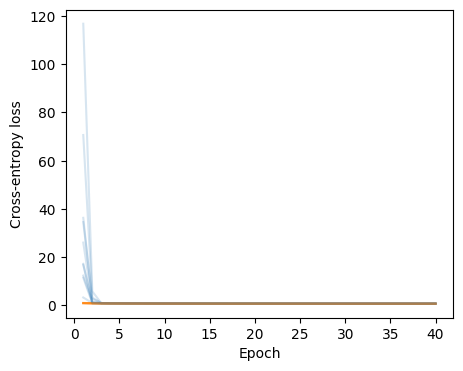

------------------------------ 
Training set:
Average log-likelihood = -5227.1 (53.2)
Average accuracy       = 69.0% (0.6%)
Average F1 score       = 62.9% (0.7%)
------------------------------ 
Validation set:
Average log-likelihood = -734.6 (8.8)
Average accuracy       = 69.6% (0.7%)
Average F1 score       = 63.0% (0.9%)
------------------------------ 
Test set:
Average log-likelihood = -1652.0 (147.8)
Average accuracy       = 68.3% (6.7%)
Average F1 score       = 66.7% (4.0%)
------------------------------ 
Training set:
Strong regularity = 1.000 (0.000)
Weak regularity   = 1.000 (0.000)
------------------------------ 
Validation set:
Strong regularity = 1.000 (0.000)
Weak regularity   = 1.000 (0.000)
------------------------------ 
Test set:
Strong regularity = 1.000 (0.000)
Weak regularity   = 1.000 (0.000)
------------------------------


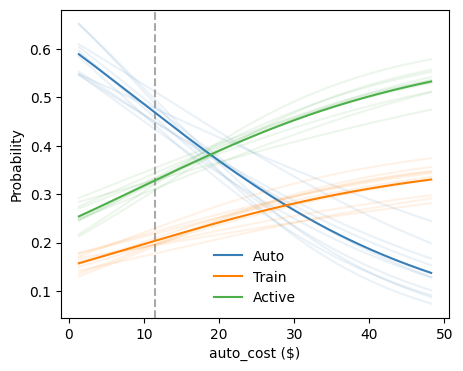

Penalty = 0.1
------------------------------
Model 1 
Training set:   LL = -5199.2 | acc = 69.4% | F1 = 63.1%
Validation set: LL = -733.0  | acc = 69.9% | F1 = 63.4%
Test set:       LL = -1628.7 | acc = 70.5% | F1 = 67.8%
Model 2 
Training set:   LL = -5011.4 | acc = 70.6% | F1 = 64.7%
Validation set: LL = -701.2  | acc = 70.0% | F1 = 63.9%
Test set:       LL = -1306.2 | acc = 78.5% | F1 = 70.7%
Model 3 
Training set:   LL = -5226.8 | acc = 68.9% | F1 = 63.1%
Validation set: LL = -736.1  | acc = 68.7% | F1 = 62.5%
Test set:       LL = -1654.5 | acc = 66.6% | F1 = 66.3%
Model 4 
Training set:   LL = -5105.4 | acc = 70.0% | F1 = 64.3%
Validation set: LL = -710.6  | acc = 71.6% | F1 = 65.6%
Test set:       LL = -1357.3 | acc = 78.5% | F1 = 70.1%
Model 5 
Training set:   LL = -5062.6 | acc = 70.4% | F1 = 64.4%
Validation set: LL = -717.1  | acc = 70.0% | F1 = 64.0%
Test set:       LL = -1373.8 | acc = 78.7% | F1 = 69.8%
Model 6 
Training set:   LL = -5157.3 | acc = 69.6% | F1 = 63.2%
Valid

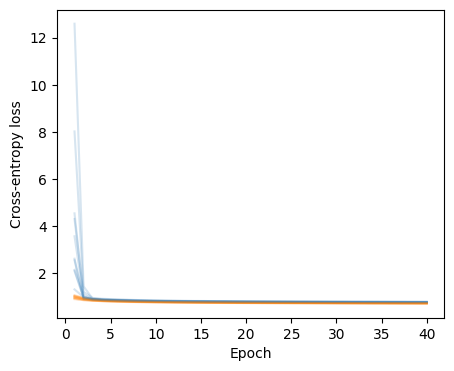

------------------------------ 
Training set:
Average log-likelihood = -5133.4 (62.2)
Average accuracy       = 69.8% (0.5%)
Average F1 score       = 63.7% (0.5%)
------------------------------ 
Validation set:
Average log-likelihood = -720.9 (9.7)
Average accuracy       = 70.2% (0.7%)
Average F1 score       = 63.9% (0.8%)
------------------------------ 
Test set:
Average log-likelihood = -1446.7 (108.7)
Average accuracy       = 75.9% (3.8%)
Average F1 score       = 69.8% (1.4%)
------------------------------ 
Training set:
Strong regularity = 0.999 (0.001)
Weak regularity   = 1.000 (0.000)
------------------------------ 
Validation set:
Strong regularity = 1.000 (0.001)
Weak regularity   = 1.000 (0.000)
------------------------------ 
Test set:
Strong regularity = 1.000 (0.001)
Weak regularity   = 1.000 (0.000)
------------------------------


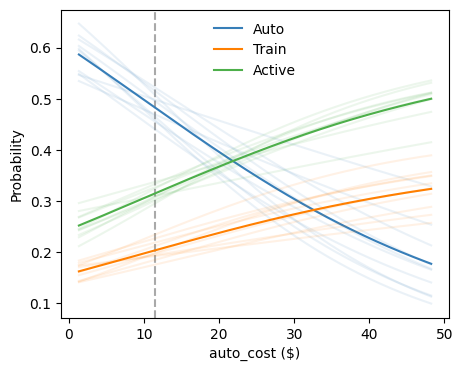

Penalty = 0.01
------------------------------
Model 1 
Training set:   LL = -5034.8 | acc = 71.0% | F1 = 65.4%
Validation set: LL = -706.3  | acc = 70.9% | F1 = 65.1%
Test set:       LL = -1291.1 | acc = 78.5% | F1 = 69.9%
Model 2 
Training set:   LL = -4789.4 | acc = 71.7% | F1 = 66.6%
Validation set: LL = -672.5  | acc = 73.2% | F1 = 68.0%
Test set:       LL = -1452.1 | acc = 78.8% | F1 = 71.8%
Model 3 
Training set:   LL = -5015.5 | acc = 70.8% | F1 = 65.2%
Validation set: LL = -704.7  | acc = 70.3% | F1 = 64.3%
Test set:       LL = -1285.9 | acc = 78.9% | F1 = 70.6%
Model 4 
Training set:   LL = -4909.9 | acc = 71.3% | F1 = 66.0%
Validation set: LL = -684.5  | acc = 73.0% | F1 = 67.8%
Test set:       LL = -1332.7 | acc = 78.5% | F1 = 69.6%
Model 5 
Training set:   LL = -4838.3 | acc = 71.6% | F1 = 66.7%
Validation set: LL = -681.4  | acc = 72.1% | F1 = 67.3%
Test set:       LL = -1341.7 | acc = 78.9% | F1 = 72.1%
Model 6 
Training set:   LL = -4986.5 | acc = 71.0% | F1 = 65.5%
Vali

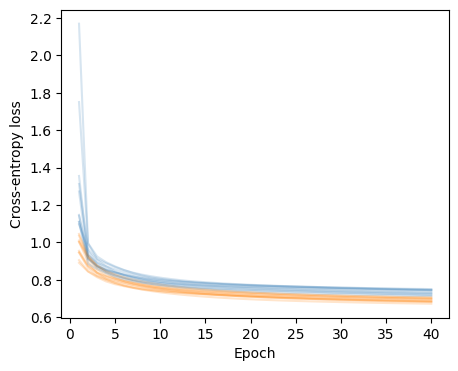

------------------------------ 
Training set:
Average log-likelihood = -4933.3 (78.3)
Average accuracy       = 71.2% (0.3%)
Average F1 score       = 65.9% (0.5%)
------------------------------ 
Validation set:
Average log-likelihood = -691.4 (10.5)
Average accuracy       = 72.0% (0.9%)
Average F1 score       = 66.6% (1.2%)
------------------------------ 
Test set:
Average log-likelihood = -1320.8 (51.4)
Average accuracy       = 78.6% (0.2%)
Average F1 score       = 70.6% (1.0%)
------------------------------ 
Training set:
Strong regularity = 1.000 (0.001)
Weak regularity   = 1.000 (0.000)
------------------------------ 
Validation set:
Strong regularity = 1.000 (0.001)
Weak regularity   = 1.000 (0.000)
------------------------------ 
Test set:
Strong regularity = 0.998 (0.002)
Weak regularity   = 1.000 (0.000)
------------------------------


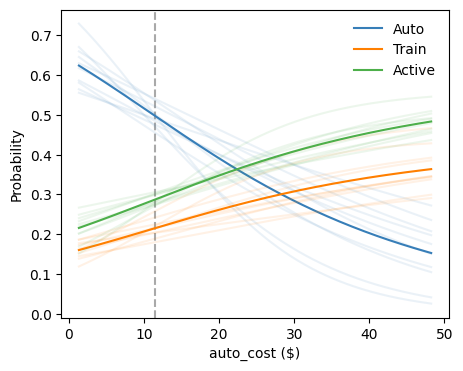

Penalty = 0.001
------------------------------
Model 1 
Training set:   LL = -4724.0 | acc = 71.9% | F1 = 67.5%
Validation set: LL = -667.2  | acc = 73.7% | F1 = 69.2%
Test set:       LL = -1403.8 | acc = 77.0% | F1 = 73.0%
Model 2 
Training set:   LL = -4627.0 | acc = 72.5% | F1 = 68.9%
Validation set: LL = -660.9  | acc = 74.7% | F1 = 71.0%
Test set:       LL = -1787.8 | acc = 73.6% | F1 = 72.7%
Model 3 
Training set:   LL = -4699.6 | acc = 72.1% | F1 = 68.0%
Validation set: LL = -668.7  | acc = 74.0% | F1 = 69.7%
Test set:       LL = -1520.0 | acc = 76.3% | F1 = 73.1%
Model 4 
Training set:   LL = -4644.0 | acc = 72.4% | F1 = 68.6%
Validation set: LL = -660.5  | acc = 74.5% | F1 = 70.7%
Test set:       LL = -1671.7 | acc = 74.7% | F1 = 73.0%
Model 5 
Training set:   LL = -4618.6 | acc = 72.4% | F1 = 68.7%
Validation set: LL = -660.7  | acc = 74.4% | F1 = 70.8%
Test set:       LL = -1718.7 | acc = 75.3% | F1 = 73.6%
Model 6 
Training set:   LL = -4690.5 | acc = 72.4% | F1 = 68.2%
Val

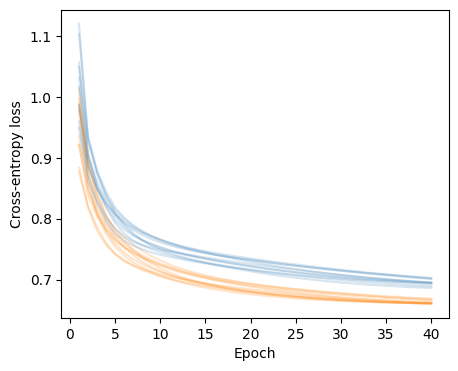

------------------------------ 
Training set:
Average log-likelihood = -4662.1 (32.1)
Average accuracy       = 72.3% (0.2%)
Average F1 score       = 68.3% (0.4%)
------------------------------ 
Validation set:
Average log-likelihood = -662.9 (3.0)
Average accuracy       = 74.2% (0.3%)
Average F1 score       = 70.1% (0.6%)
------------------------------ 
Test set:
Average log-likelihood = -1601.8 (112.7)
Average accuracy       = 75.4% (1.0%)
Average F1 score       = 73.0% (0.3%)
------------------------------ 
Training set:
Strong regularity = 1.000 (0.000)
Weak regularity   = 1.000 (0.000)
------------------------------ 
Validation set:
Strong regularity = 1.000 (0.000)
Weak regularity   = 1.000 (0.000)
------------------------------ 
Test set:
Strong regularity = 0.990 (0.003)
Weak regularity   = 1.000 (0.000)
------------------------------


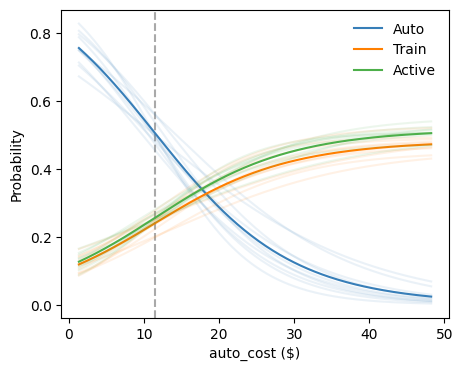

Penalty = 0.0001
------------------------------
Model 1 
Training set:   LL = -4605.0 | acc = 72.4% | F1 = 68.8%
Validation set: LL = -659.5  | acc = 74.4% | F1 = 70.6%
Test set:       LL = -1831.9 | acc = 73.5% | F1 = 72.7%
Model 2 
Training set:   LL = -4605.3 | acc = 72.6% | F1 = 69.1%
Validation set: LL = -661.6  | acc = 74.6% | F1 = 71.0%
Test set:       LL = -1862.5 | acc = 72.8% | F1 = 72.3%
Model 3 
Training set:   LL = -4598.3 | acc = 72.7% | F1 = 69.3%
Validation set: LL = -663.0  | acc = 74.4% | F1 = 70.7%
Test set:       LL = -1911.4 | acc = 72.5% | F1 = 72.1%
Model 4 
Training set:   LL = -4590.2 | acc = 72.6% | F1 = 69.2%
Validation set: LL = -658.5  | acc = 74.5% | F1 = 71.2%
Test set:       LL = -1961.1 | acc = 71.9% | F1 = 71.7%
Model 5 
Training set:   LL = -4594.6 | acc = 72.7% | F1 = 69.2%
Validation set: LL = -659.5  | acc = 74.9% | F1 = 71.4%
Test set:       LL = -1868.7 | acc = 73.4% | F1 = 72.6%
Model 6 
Training set:   LL = -4590.2 | acc = 72.7% | F1 = 69.2%
Va

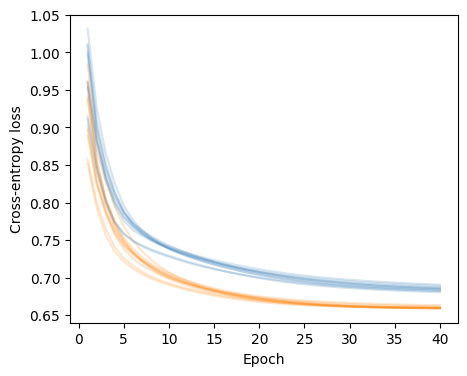

------------------------------ 
Training set:
Average log-likelihood = -4595.5 (9.6)
Average accuracy       = 72.7% (0.1%)
Average F1 score       = 69.2% (0.2%)
------------------------------ 
Validation set:
Average log-likelihood = -660.0 (1.3)
Average accuracy       = 74.6% (0.2%)
Average F1 score       = 71.0% (0.3%)
------------------------------ 
Test set:
Average log-likelihood = -1901.4 (36.6)
Average accuracy       = 72.5% (0.6%)
Average F1 score       = 72.0% (0.4%)
------------------------------ 
Training set:
Strong regularity = 0.999 (0.001)
Weak regularity   = 1.000 (0.001)
------------------------------ 
Validation set:
Strong regularity = 1.000 (0.001)
Weak regularity   = 1.000 (0.001)
------------------------------ 
Test set:
Strong regularity = 0.978 (0.004)
Weak regularity   = 1.000 (0.000)
------------------------------


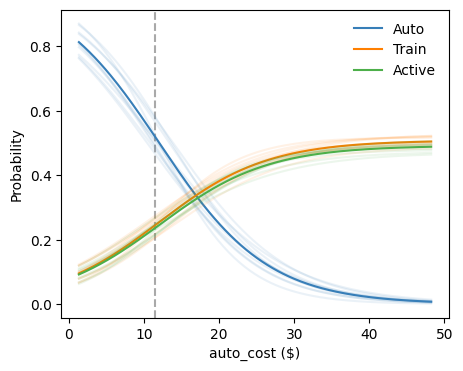

Penalty = 1e-05
------------------------------
Model 1 
Training set:   LL = -4598.2 | acc = 72.5% | F1 = 69.0%
Validation set: LL = -659.8  | acc = 74.4% | F1 = 70.7%
Test set:       LL = -1917.9 | acc = 72.1% | F1 = 71.9%
Model 2 
Training set:   LL = -4600.8 | acc = 72.6% | F1 = 69.1%
Validation set: LL = -662.1  | acc = 74.7% | F1 = 71.0%
Test set:       LL = -1903.6 | acc = 72.4% | F1 = 72.1%
Model 3 
Training set:   LL = -4597.0 | acc = 72.6% | F1 = 69.2%
Validation set: LL = -662.9  | acc = 74.4% | F1 = 70.5%
Test set:       LL = -1930.2 | acc = 71.8% | F1 = 71.6%
Model 4 
Training set:   LL = -4586.4 | acc = 72.6% | F1 = 69.2%
Validation set: LL = -658.1  | acc = 74.7% | F1 = 71.2%
Test set:       LL = -2016.2 | acc = 70.6% | F1 = 70.8%
Model 5 
Training set:   LL = -4591.7 | acc = 72.7% | F1 = 69.3%
Validation set: LL = -659.7  | acc = 74.4% | F1 = 70.7%
Test set:       LL = -1911.5 | acc = 72.2% | F1 = 71.8%
Model 6 
Training set:   LL = -4584.6 | acc = 72.8% | F1 = 69.3%
Val

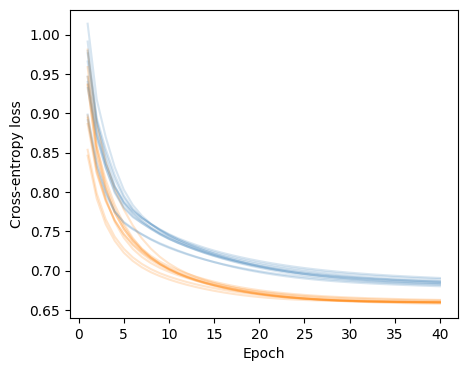

------------------------------ 
Training set:
Average log-likelihood = -4591.3 (10.8)
Average accuracy       = 72.7% (0.1%)
Average F1 score       = 69.2% (0.1%)
------------------------------ 
Validation set:
Average log-likelihood = -660.2 (1.3)
Average accuracy       = 74.5% (0.2%)
Average F1 score       = 70.9% (0.3%)
------------------------------ 
Test set:
Average log-likelihood = -1961.0 (42.2)
Average accuracy       = 71.5% (0.7%)
Average F1 score       = 71.5% (0.5%)
------------------------------ 
Training set:
Strong regularity = 0.999 (0.001)
Weak regularity   = 0.999 (0.001)
------------------------------ 
Validation set:
Strong regularity = 1.000 (0.001)
Weak regularity   = 1.000 (0.001)
------------------------------ 
Test set:
Strong regularity = 0.978 (0.005)
Weak regularity   = 1.000 (0.001)
------------------------------


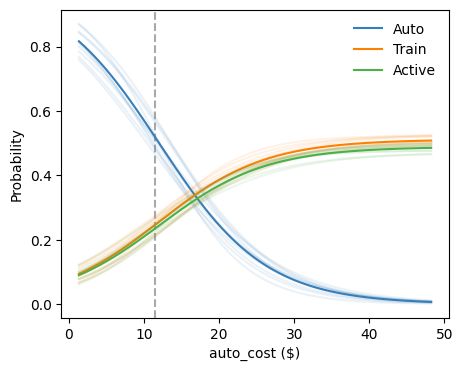

------------------------------ 
Model comparison:


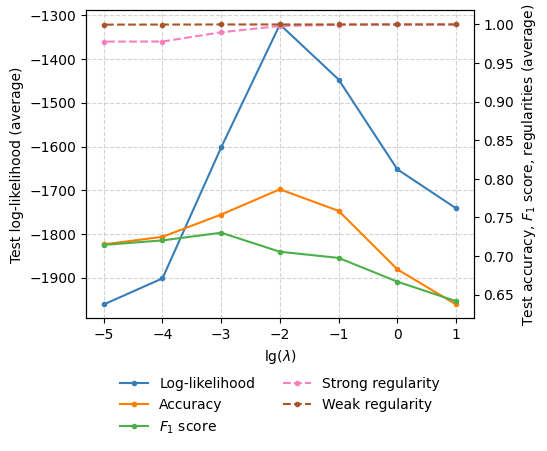

In [ ]:
result(TasteNet, 40, 'UGR', [10**i for i in range(1, -6, -1)])

### LGR

Penalty = 10
------------------------------
Model 1 
Training set:   LL = -6363.7 | acc = 64.4% | F1 = 54.6%
Validation set: LL = -905.9  | acc = 64.5% | F1 = 54.3%
Test set:       LL = -2606.1 | acc = 21.1% | F1 = 24.9%
Model 2 
Training set:   LL = -5957.0 | acc = 63.7% | F1 = 53.7%
Validation set: LL = -842.3  | acc = 63.8% | F1 = 53.1%
Test set:       LL = -2291.3 | acc = 23.8% | F1 = 29.6%
Model 3 
Training set:   LL = -6231.4 | acc = 65.3% | F1 = 53.7%
Validation set: LL = -896.4  | acc = 65.7% | F1 = 53.3%
Test set:       LL = -2335.4 | acc = 24.8% | F1 = 30.1%
Model 4 
Training set:   LL = -5938.4 | acc = 65.5% | F1 = 53.6%
Validation set: LL = -850.9  | acc = 66.0% | F1 = 53.8%
Test set:       LL = -1932.2 | acc = 55.5% | F1 = 59.3%
Model 5 
Training set:   LL = -5519.8 | acc = 67.1% | F1 = 57.7%
Validation set: LL = -784.7  | acc = 67.0% | F1 = 57.7%
Test set:       LL = -2185.2 | acc = 35.8% | F1 = 43.8%
Model 6 
Training set:   LL = -6087.4 | acc = 62.9% | F1 = 53.5%
Valida

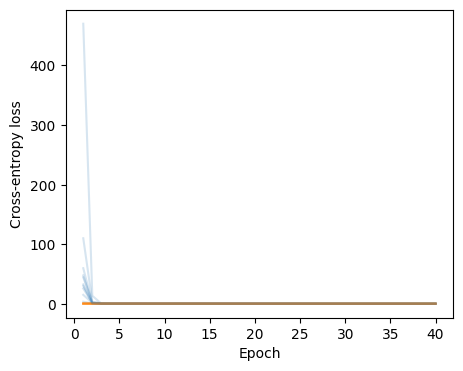

------------------------------ 
Training set:
Average log-likelihood = -5966.3 (270.5)
Average accuracy       = 65.2% (1.2%)
Average F1 score       = 54.6% (1.4%)
------------------------------ 
Validation set:
Average log-likelihood = -849.4 (41.0)
Average accuracy       = 65.5% (1.1%)
Average F1 score       = 54.7% (1.7%)
------------------------------ 
Test set:
Average log-likelihood = -2264.3 (272.6)
Average accuracy       = 34.9% (13.3%)
Average F1 score       = 40.6% (13.0%)
------------------------------ 
Training set:
Strong regularity = 1.000 (0.000)
Weak regularity   = 1.000 (0.000)
------------------------------ 
Validation set:
Strong regularity = 1.000 (0.000)
Weak regularity   = 1.000 (0.000)
------------------------------ 
Test set:
Strong regularity = 1.000 (0.000)
Weak regularity   = 1.000 (0.000)
------------------------------


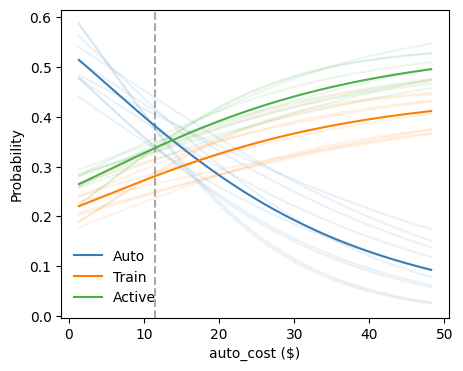

Penalty = 1
------------------------------
Model 1 
Training set:   LL = -5601.5 | acc = 66.3% | F1 = 53.7%
Validation set: LL = -797.3  | acc = 66.6% | F1 = 53.7%
Test set:       LL = -2050.0 | acc = 43.9% | F1 = 50.6%
Model 2 
Training set:   LL = -5301.6 | acc = 68.6% | F1 = 59.4%
Validation set: LL = -745.7  | acc = 68.9% | F1 = 60.0%
Test set:       LL = -1622.3 | acc = 69.9% | F1 = 66.5%
Model 3 
Training set:   LL = -5927.7 | acc = 65.4% | F1 = 53.6%
Validation set: LL = -853.4  | acc = 65.5% | F1 = 53.2%
Test set:       LL = -2213.5 | acc = 32.8% | F1 = 39.4%
Model 4 
Training set:   LL = -5282.5 | acc = 68.6% | F1 = 58.7%
Validation set: LL = -746.9  | acc = 69.3% | F1 = 60.1%
Test set:       LL = -1497.6 | acc = 77.2% | F1 = 69.0%
Model 5 
Training set:   LL = -5093.9 | acc = 70.5% | F1 = 64.2%
Validation set: LL = -724.6  | acc = 70.0% | F1 = 63.7%
Test set:       LL = -1450.6 | acc = 77.7% | F1 = 69.8%
Model 6 
Training set:   LL = -5446.0 | acc = 66.3% | F1 = 53.8%
Validat

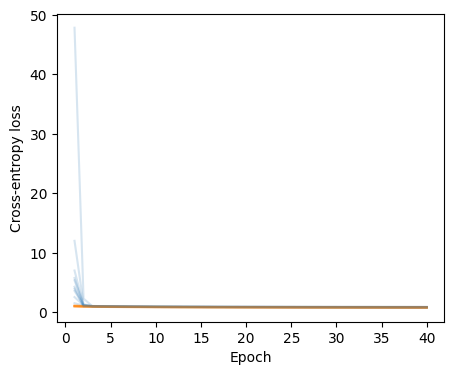

------------------------------ 
Training set:
Average log-likelihood = -5417.4 (217.8)
Average accuracy       = 67.7% (1.4%)
Average F1 score       = 57.3% (3.4%)
------------------------------ 
Validation set:
Average log-likelihood = -769.7 (34.9)
Average accuracy       = 68.0% (1.5%)
Average F1 score       = 57.7% (3.6%)
------------------------------ 
Test set:
Average log-likelihood = -1754.6 (250.0)
Average accuracy       = 61.9% (14.9%)
Average F1 score       = 60.9% (9.8%)
------------------------------ 
Training set:
Strong regularity = 1.000 (0.000)
Weak regularity   = 1.000 (0.000)
------------------------------ 
Validation set:
Strong regularity = 1.000 (0.000)
Weak regularity   = 1.000 (0.000)
------------------------------ 
Test set:
Strong regularity = 1.000 (0.000)
Weak regularity   = 1.000 (0.000)
------------------------------


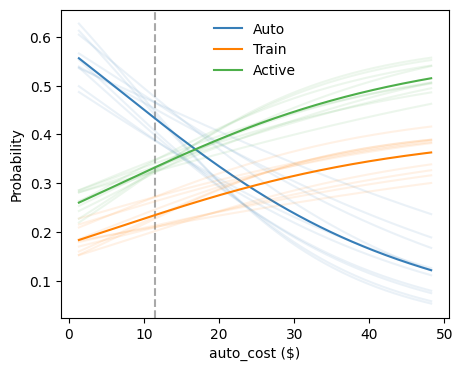

Penalty = 0.1
------------------------------
Model 1 
Training set:   LL = -5127.4 | acc = 70.3% | F1 = 63.8%
Validation set: LL = -722.1  | acc = 71.3% | F1 = 64.8%
Test set:       LL = -1422.4 | acc = 77.1% | F1 = 69.3%
Model 2 
Training set:   LL = -4886.6 | acc = 71.2% | F1 = 65.5%
Validation set: LL = -684.2  | acc = 71.6% | F1 = 66.0%
Test set:       LL = -1345.3 | acc = 78.5% | F1 = 70.2%
Model 3 
Training set:   LL = -5239.1 | acc = 68.9% | F1 = 60.6%
Validation set: LL = -746.1  | acc = 69.2% | F1 = 60.7%
Test set:       LL = -1534.5 | acc = 75.1% | F1 = 69.5%
Model 4 
Training set:   LL = -4956.0 | acc = 70.8% | F1 = 65.2%
Validation set: LL = -691.2  | acc = 72.5% | F1 = 66.9%
Test set:       LL = -1301.5 | acc = 78.3% | F1 = 69.1%
Model 5 
Training set:   LL = -4857.9 | acc = 71.5% | F1 = 66.5%
Validation set: LL = -685.2  | acc = 72.1% | F1 = 67.2%
Test set:       LL = -1345.6 | acc = 78.8% | F1 = 71.9%
Model 6 
Training set:   LL = -5059.9 | acc = 70.5% | F1 = 64.4%
Valid

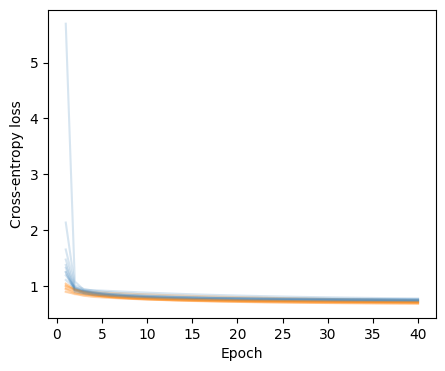

------------------------------ 
Training set:
Average log-likelihood = -5023.5 (110.0)
Average accuracy       = 70.6% (0.7%)
Average F1 score       = 64.5% (1.5%)
------------------------------ 
Validation set:
Average log-likelihood = -706.7 (17.8)
Average accuracy       = 71.3% (0.9%)
Average F1 score       = 65.2% (1.8%)
------------------------------ 
Test set:
Average log-likelihood = -1352.5 (70.4)
Average accuracy       = 78.0% (1.1%)
Average F1 score       = 69.9% (0.8%)
------------------------------ 
Training set:
Strong regularity = 0.999 (0.001)
Weak regularity   = 1.000 (0.000)
------------------------------ 
Validation set:
Strong regularity = 0.999 (0.002)
Weak regularity   = 1.000 (0.000)
------------------------------ 
Test set:
Strong regularity = 0.999 (0.002)
Weak regularity   = 1.000 (0.000)
------------------------------


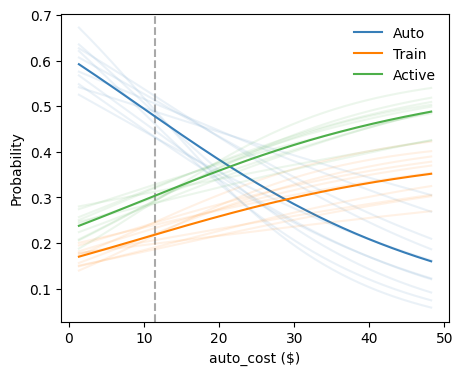

Penalty = 0.01
------------------------------
Model 1 
Training set:   LL = -4813.3 | acc = 71.7% | F1 = 66.7%
Validation set: LL = -675.7  | acc = 72.9% | F1 = 67.9%
Test set:       LL = -1299.8 | acc = 78.8% | F1 = 71.4%
Model 2 
Training set:   LL = -4666.2 | acc = 72.3% | F1 = 68.4%
Validation set: LL = -663.5  | acc = 75.0% | F1 = 71.1%
Test set:       LL = -1661.3 | acc = 75.6% | F1 = 73.6%
Model 3 
Training set:   LL = -4793.6 | acc = 71.8% | F1 = 66.8%
Validation set: LL = -677.3  | acc = 72.6% | F1 = 67.7%
Test set:       LL = -1361.4 | acc = 78.4% | F1 = 71.9%
Model 4 
Training set:   LL = -4685.7 | acc = 72.2% | F1 = 68.2%
Validation set: LL = -662.9  | acc = 74.8% | F1 = 70.6%
Test set:       LL = -1559.7 | acc = 76.4% | F1 = 73.3%
Model 5 
Training set:   LL = -4630.8 | acc = 72.3% | F1 = 68.6%
Validation set: LL = -660.8  | acc = 74.3% | F1 = 70.6%
Test set:       LL = -1683.9 | acc = 75.5% | F1 = 73.5%
Model 6 
Training set:   LL = -4751.0 | acc = 71.9% | F1 = 67.4%
Vali

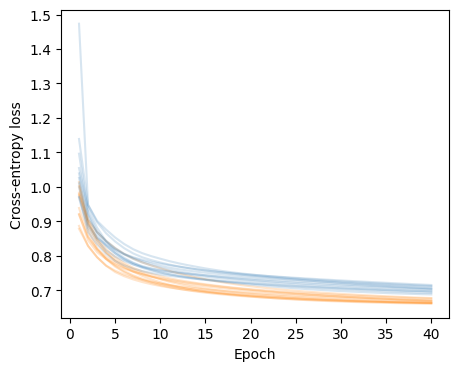

------------------------------ 
Training set:
Average log-likelihood = -4719.3 (56.2)
Average accuracy       = 72.0% (0.3%)
Average F1 score       = 67.6% (0.7%)
------------------------------ 
Validation set:
Average log-likelihood = -667.5 (5.4)
Average accuracy       = 73.8% (0.8%)
Average F1 score       = 69.3% (1.2%)
------------------------------ 
Test set:
Average log-likelihood = -1483.3 (128.3)
Average accuracy       = 77.2% (1.2%)
Average F1 score       = 72.9% (0.7%)
------------------------------ 
Training set:
Strong regularity = 1.000 (0.001)
Weak regularity   = 1.000 (0.001)
------------------------------ 
Validation set:
Strong regularity = 1.000 (0.001)
Weak regularity   = 1.000 (0.000)
------------------------------ 
Test set:
Strong regularity = 0.991 (0.003)
Weak regularity   = 1.000 (0.000)
------------------------------


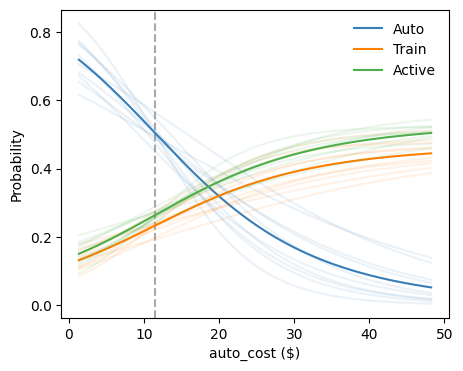

Penalty = 0.001
------------------------------
Model 1 
Training set:   LL = -4612.5 | acc = 72.3% | F1 = 68.6%
Validation set: LL = -660.0  | acc = 74.3% | F1 = 70.4%
Test set:       LL = -1809.5 | acc = 73.4% | F1 = 72.7%
Model 2 
Training set:   LL = -4611.3 | acc = 72.6% | F1 = 69.0%
Validation set: LL = -661.4  | acc = 74.7% | F1 = 71.1%
Test set:       LL = -1847.2 | acc = 73.1% | F1 = 72.5%
Model 3 
Training set:   LL = -4613.7 | acc = 72.4% | F1 = 68.9%
Validation set: LL = -663.6  | acc = 73.9% | F1 = 69.9%
Test set:       LL = -1831.3 | acc = 73.7% | F1 = 72.9%
Model 4 
Training set:   LL = -4594.0 | acc = 72.5% | F1 = 69.1%
Validation set: LL = -658.2  | acc = 74.6% | F1 = 71.2%
Test set:       LL = -1952.9 | acc = 71.6% | F1 = 71.5%
Model 5 
Training set:   LL = -4597.4 | acc = 72.7% | F1 = 69.2%
Validation set: LL = -659.4  | acc = 74.5% | F1 = 70.8%
Test set:       LL = -1855.0 | acc = 73.5% | F1 = 72.7%
Model 6 
Training set:   LL = -4595.9 | acc = 72.7% | F1 = 69.2%
Val

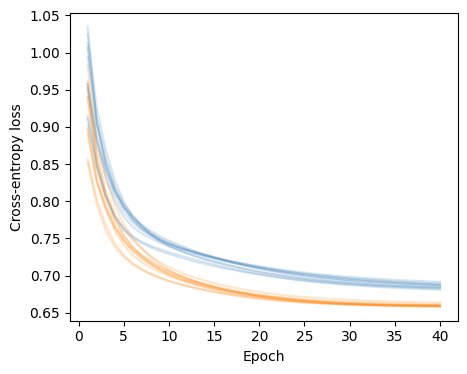

------------------------------ 
Training set:
Average log-likelihood = -4601.7 (11.6)
Average accuracy       = 72.6% (0.2%)
Average F1 score       = 69.1% (0.2%)
------------------------------ 
Validation set:
Average log-likelihood = -659.8 (1.5)
Average accuracy       = 74.4% (0.3%)
Average F1 score       = 70.8% (0.4%)
------------------------------ 
Test set:
Average log-likelihood = -1876.6 (40.4)
Average accuracy       = 72.6% (0.7%)
Average F1 score       = 72.1% (0.5%)
------------------------------ 
Training set:
Strong regularity = 0.999 (0.001)
Weak regularity   = 1.000 (0.001)
------------------------------ 
Validation set:
Strong regularity = 1.000 (0.000)
Weak regularity   = 1.000 (0.000)
------------------------------ 
Test set:
Strong regularity = 0.981 (0.004)
Weak regularity   = 1.000 (0.000)
------------------------------


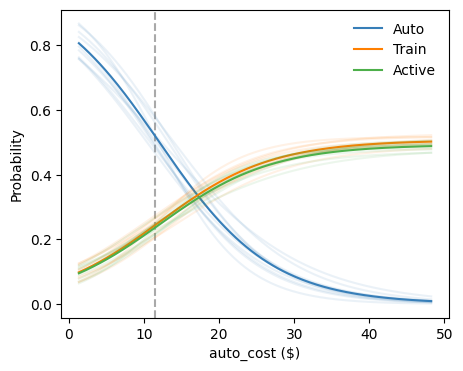

Penalty = 0.0001
------------------------------
Model 1 
Training set:   LL = -4598.3 | acc = 72.5% | F1 = 69.0%
Validation set: LL = -659.7  | acc = 74.5% | F1 = 70.9%
Test set:       LL = -1952.8 | acc = 71.2% | F1 = 71.2%
Model 2 
Training set:   LL = -4601.0 | acc = 72.6% | F1 = 69.1%
Validation set: LL = -661.8  | acc = 74.6% | F1 = 71.0%
Test set:       LL = -1923.4 | acc = 71.7% | F1 = 71.7%
Model 3 
Training set:   LL = -4597.7 | acc = 72.6% | F1 = 69.1%
Validation set: LL = -663.0  | acc = 74.3% | F1 = 70.4%
Test set:       LL = -1969.2 | acc = 71.2% | F1 = 71.3%
Model 4 
Training set:   LL = -4585.8 | acc = 72.6% | F1 = 69.2%
Validation set: LL = -657.9  | acc = 74.6% | F1 = 71.2%
Test set:       LL = -2055.6 | acc = 69.5% | F1 = 70.1%
Model 5 
Training set:   LL = -4590.6 | acc = 72.7% | F1 = 69.3%
Validation set: LL = -659.7  | acc = 74.5% | F1 = 70.8%
Test set:       LL = -1958.7 | acc = 71.3% | F1 = 71.3%
Model 6 
Training set:   LL = -4583.8 | acc = 72.8% | F1 = 69.4%
Va

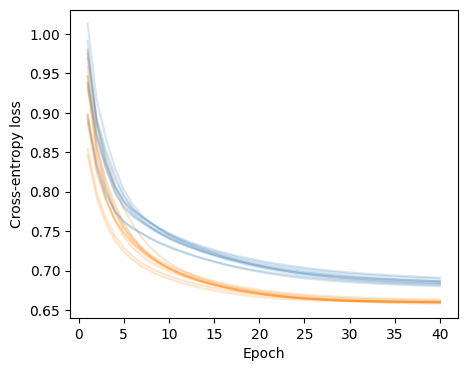

------------------------------ 
Training set:
Average log-likelihood = -4590.9 (11.3)
Average accuracy       = 72.7% (0.1%)
Average F1 score       = 69.2% (0.1%)
------------------------------ 
Validation set:
Average log-likelihood = -660.2 (1.3)
Average accuracy       = 74.5% (0.2%)
Average F1 score       = 70.9% (0.3%)
------------------------------ 
Test set:
Average log-likelihood = -2003.9 (50.2)
Average accuracy       = 70.5% (0.8%)
Average F1 score       = 70.8% (0.6%)
------------------------------ 
Training set:
Strong regularity = 0.999 (0.001)
Weak regularity   = 0.999 (0.001)
------------------------------ 
Validation set:
Strong regularity = 1.000 (0.001)
Weak regularity   = 1.000 (0.001)
------------------------------ 
Test set:
Strong regularity = 0.981 (0.004)
Weak regularity   = 1.000 (0.001)
------------------------------


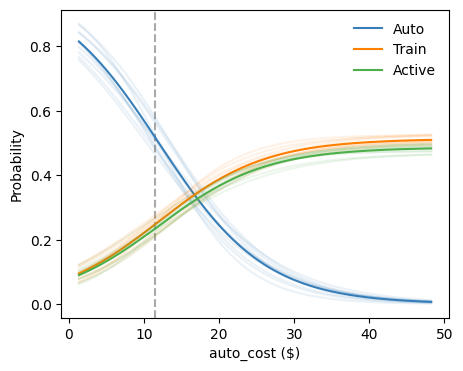

Penalty = 1e-05
------------------------------
Model 1 
Training set:   LL = -4595.8 | acc = 72.6% | F1 = 69.1%
Validation set: LL = -660.7  | acc = 74.4% | F1 = 70.8%
Test set:       LL = -2066.8 | acc = 68.8% | F1 = 69.7%
Model 2 
Training set:   LL = -4599.0 | acc = 72.6% | F1 = 69.1%
Validation set: LL = -662.7  | acc = 74.6% | F1 = 70.9%
Test set:       LL = -2005.5 | acc = 70.0% | F1 = 70.5%
Model 3 
Training set:   LL = -4595.2 | acc = 72.6% | F1 = 69.1%
Validation set: LL = -663.7  | acc = 74.3% | F1 = 70.4%
Test set:       LL = -2074.4 | acc = 69.5% | F1 = 70.2%
Model 4 
Training set:   LL = -4583.8 | acc = 72.6% | F1 = 69.2%
Validation set: LL = -658.3  | acc = 74.6% | F1 = 71.1%
Test set:       LL = -2156.9 | acc = 67.5% | F1 = 68.7%
Model 5 
Training set:   LL = -4589.3 | acc = 72.7% | F1 = 69.3%
Validation set: LL = -660.5  | acc = 74.6% | F1 = 70.9%
Test set:       LL = -2055.3 | acc = 69.5% | F1 = 70.0%
Model 6 
Training set:   LL = -4581.5 | acc = 72.8% | F1 = 69.3%
Val

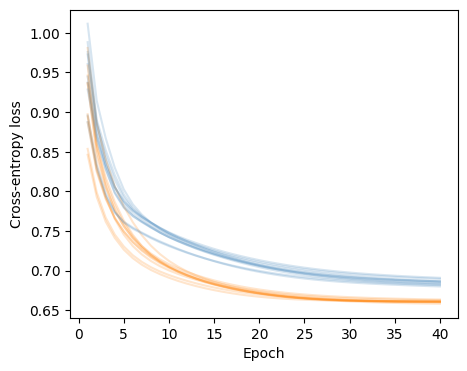

------------------------------ 
Training set:
Average log-likelihood = -4588.7 (11.2)
Average accuracy       = 72.7% (0.1%)
Average F1 score       = 69.2% (0.1%)
------------------------------ 
Validation set:
Average log-likelihood = -661.0 (1.4)
Average accuracy       = 74.5% (0.2%)
Average F1 score       = 70.8% (0.3%)
------------------------------ 
Test set:
Average log-likelihood = -2118.2 (68.8)
Average accuracy       = 68.2% (1.3%)
Average F1 score       = 69.2% (1.0%)
------------------------------ 
Training set:
Strong regularity = 0.999 (0.001)
Weak regularity   = 0.999 (0.001)
------------------------------ 
Validation set:
Strong regularity = 1.000 (0.001)
Weak regularity   = 1.000 (0.001)
------------------------------ 
Test set:
Strong regularity = 0.983 (0.004)
Weak regularity   = 1.000 (0.001)
------------------------------


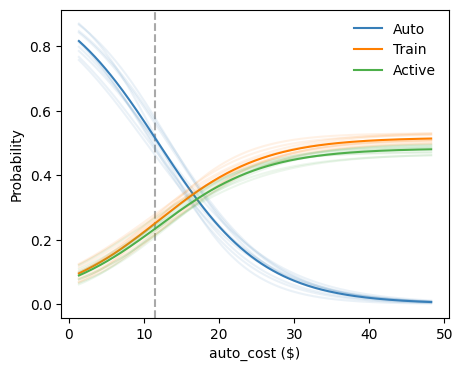

------------------------------ 
Model comparison:


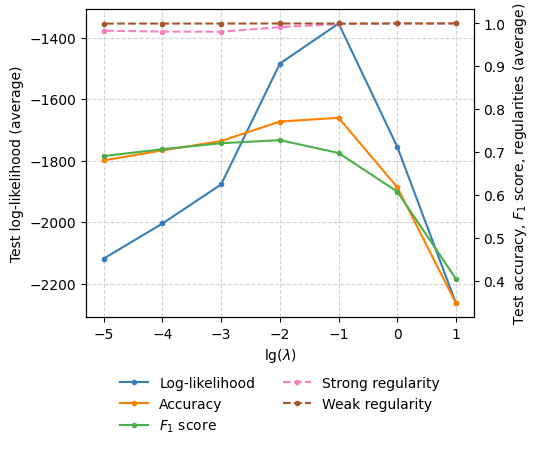

In [ ]:
result(TasteNet, 40, 'LGR', [10**i for i in range(1, -6, -1)])

# Final results

In [ ]:
weights = np.array([2/val_size, .5, .5, 1, 1])
scores = results_val.multiply(weights, axis=0).sum()
l_col = []
for model in ['DNN', 'TasteNet']:
    l_col.append(model)
    for GR in ['PGR', 'UGR', 'LGR']:
        l_col.append(scores[scores.index.str.startswith(f'{model}, sum-{GR}')].idxmax())
l_col.append('MNL')

In [ ]:
results_train = results_train[l_col]
results_val = results_val[l_col].iloc[:5]
results_test = results_test[l_col]

results_train_std = results_train_std[l_col]
results_val_std = results_val_std[l_col]
results_test_std = results_test_std[l_col]

In [ ]:
results_train.to_csv(f'{path}/Regularity_results/10K_S_Chicago_train.csv')
results_val.to_csv(f'{path}/Regularity_results/10K_S_Chicago_val.csv')
results_test.to_csv(f'{path}/Regularity_results/10K_S_Chicago_test.csv')

results_train_std.to_csv(f'{path}/Regularity_results/10K_S_Chicago_train_std.csv')
results_val_std.to_csv(f'{path}/Regularity_results/10K_S_Chicago_val_std.csv')
results_test_std.to_csv(f'{path}/Regularity_results/10K_S_Chicago_test_std.csv')

In [ ]:
results_train.iloc[0] = results_train.iloc[0].round(1)
results_val.iloc[0] = results_val.iloc[0].round(1)
results_test.iloc[0] = results_test.iloc[0].round(1)

In [ ]:
df_train = results_train.round(3).astype(str).add(' (').add(results_train_std.round(3).astype(str)).add(')')
df_val = results_val.round(3).astype(str).add(' (').add(results_val_std.round(3).astype(str)).add(')')
df_test = results_test.round(3).astype(str).add(' (').add(results_test_std.round(3).astype(str)).add(')')

In [ ]:
print(df_train.to_latex())

\begin{tabular}{llllllllll}
\toprule
 & DNN & DNN, sum-PGR (0.1) & DNN, sum-UGR (0.1) & DNN, sum-LGR (0.1) & TasteNet & TasteNet, sum-PGR (0.001) & TasteNet, sum-UGR (0.0001) & TasteNet, sum-LGR (0.0001) & MNL \\
\midrule
Log-likelihood & -4292.7 (21.52) & -4325.0 (17.677) & -4398.3 (13.498) & -4350.1 (20.772) & -4847.9 (28.64) & -4600.0 (9.302) & -4595.5 (9.634) & -4590.9 (11.262) & -4720.0 (0) \\
Accuracy & 0.745 (0.002) & 0.742 (0.002) & 0.738 (0.002) & 0.741 (0.002) & 0.715 (0.001) & 0.726 (0.001) & 0.727 (0.001) & 0.727 (0.001) & 0.726 (0) \\
F1 score & 0.717 (0.003) & 0.714 (0.003) & 0.707 (0.002) & 0.713 (0.003) & 0.661 (0.002) & 0.691 (0.002) & 0.692 (0.002) & 0.692 (0.001) & 0.693 (0) \\
Strong regularity & 0.881 (0.045) & 0.998 (0.001) & 0.998 (0.001) & 0.998 (0.001) & 1.0 (0.0) & 1.0 (0.001) & 0.999 (0.001) & 0.999 (0.001) & 1.0 (0) \\
Weak regularity & 0.898 (0.042) & 1.0 (0.0) & 1.0 (0.0) & 1.0 (0.0) & 1.0 (0.0) & 1.0 (0.001) & 1.0 (0.001) & 0.999 (0.001) & 1.0 (0) \\
\bot

In [ ]:
print(df_val.to_latex())

\begin{tabular}{llllllllll}
\toprule
 & DNN & DNN, sum-PGR (0.1) & DNN, sum-UGR (0.1) & DNN, sum-LGR (0.1) & TasteNet & TasteNet, sum-PGR (0.001) & TasteNet, sum-UGR (0.0001) & TasteNet, sum-LGR (0.0001) & MNL \\
\midrule
Log-likelihood & -656.6 (4.636) & -647.9 (3.43) & -648.5 (2.176) & -646.9 (2.397) & -683.0 (3.344) & -660.1 (1.171) & -660.0 (1.316) & -660.2 (1.32) & -673.2 (0) \\
Accuracy & 0.737 (0.003) & 0.739 (0.002) & 0.737 (0.004) & 0.739 (0.003) & 0.729 (0.004) & 0.745 (0.003) & 0.746 (0.002) & 0.745 (0.002) & 0.745 (0) \\
F1 score & 0.703 (0.004) & 0.707 (0.002) & 0.704 (0.005) & 0.707 (0.005) & 0.675 (0.005) & 0.709 (0.004) & 0.71 (0.003) & 0.709 (0.003) & 0.711 (0) \\
Strong regularity & 0.883 (0.045) & 0.998 (0.001) & 0.998 (0.001) & 0.998 (0.001) & 1.0 (0.0) & 1.0 (0.001) & 1.0 (0.001) & 1.0 (0.001) & 1.0 (0) \\
Weak regularity & 0.898 (0.042) & 0.999 (0.001) & 1.0 (0.0) & 1.0 (0.0) & 1.0 (0.0) & 1.0 (0.001) & 1.0 (0.001) & 1.0 (0.001) & 1.0 (0) \\
\bottomrule
\end{tabul

In [ ]:
print(df_test.to_latex())

\begin{tabular}{llllllllll}
\toprule
 & DNN & DNN, sum-PGR (0.1) & DNN, sum-UGR (0.1) & DNN, sum-LGR (0.1) & TasteNet & TasteNet, sum-PGR (0.001) & TasteNet, sum-UGR (0.0001) & TasteNet, sum-LGR (0.0001) & MNL \\
\midrule
Log-likelihood & -1356.1 (134.06) & -1243.5 (55.145) & -1167.9 (27.639) & -1232.4 (54.874) & -1485.9 (47.923) & -1873.7 (45.519) & -1901.4 (36.618) & -2003.9 (50.228) & -2025.7 (0) \\
Accuracy & 0.783 (0.011) & 0.788 (0.002) & 0.789 (0.003) & 0.788 (0.002) & 0.75 (0.014) & 0.726 (0.008) & 0.725 (0.006) & 0.705 (0.008) & 0.722 (0) \\
F1 score & 0.722 (0.01) & 0.726 (0.006) & 0.727 (0.003) & 0.724 (0.005) & 0.707 (0.006) & 0.721 (0.005) & 0.72 (0.004) & 0.708 (0.006) & 0.721 (0) \\
Strong regularity & 0.317 (0.24) & 0.857 (0.099) & 0.923 (0.087) & 0.865 (0.071) & 1.0 (0.0) & 0.98 (0.004) & 0.978 (0.004) & 0.981 (0.004) & 0.984 (0) \\
Weak regularity & 0.487 (0.23) & 0.974 (0.037) & 0.983 (0.04) & 0.977 (0.023) & 1.0 (0.0) & 1.0 (0.0) & 1.0 (0.0) & 1.0 (0.001) & 1.0 (0) 